# Understanding Society

Standard access data comes under 3 settings: the main survey (BHPS+UKHLS), the innovation panel survey (survey testbed) and the nurse surveys (UKHLS Waves 2 and 3). Each of the settings have multiple waves, in each of which some questions would overlap while others won't. (For instance, social network information is only in waves 3 and 6 of UKHLS.)

## Links to relevant survey variables

### Main Survey
1. Socio-demographics:https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/socio-demographic-characteristics

2. Social networks (mostly wave 3 and 6): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/social-support-networks, **"Proportion of friends"** type of questions: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/wave/3/questionnaire-module/socialnetworks_w3

3. Religion: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/religion

4. Psychology (like big 5, cognitive ability, mostly wave 3): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/psychological-characteristics

5. Health conditions: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-personal-health-condition

6. Subjective well-being: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-subjective-well-being

7. Smoking: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-smoking

8. Education: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/education-background-and-attainments

9. Income: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/incomes

10. Employment (BIG): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/employment-labour-force-status

11. Opinions and attitudes:https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/values-opinions-and-attitudes

12. Geography and safety: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/geographic-location

13. Environment (mostly wave 4): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/employment-labour-force-status

### Note on Nominee Dimensions

We only have sex, age, ethnicity, employment (and distance). We would possibly like to have income (or class), education, sexual orientation, religion, language...

### Nurse Visits

1. Health tests and measurements: https://www.understandingsociety.ac.uk/documentation/health-assessment/dataset-documentation/wave/xwave/datafile/xindresp_ns

2. Blood biomarkers: https://www.understandingsociety.ac.uk/documentation/health-assessment/dataset-documentation/wave/xwave/datafile/xlabblood_ns

## Accessing Data

Data was collected from UK Data Services. The actual data can be straight-forwardly parsed (see below), however the metadata of variable descriptions are non-trivial to parse (the "data dictionaries" exist in RTF formats!) So we had to go through them the long manual way.

## Cross-Wave Analysis

1. Infer connectivity kernel from Wave 3, 6; which Blau dimensions?
2. Derive individual's social isolation, for all individual respondents, in all waves offering Smoking, Psychology, Health, Well-being
3. Regression from individual isolation to indicators. How?

### TO DO: Regression Strategy
1. Say we pick binary indicators only.
2. Logistic Regression with gaussian additive noise: some kind of a constant scaling of the original weights of the kernel; quite easy to interpret!
3. Alternately to 2, log-reg with "GP" priors: (a) if prior kernel is learnable, we can obtain meta-homophily beyond connectivity (b) if prior kernel is some scaling of connectivity kernel, we again reach an idea similar to 2 except some notion of pairwise isolation instead of individual: however, this can be confounding, (c) a multi-output GP kernel that learns both individual isolation and binary indicator (separable)

## Extracting Relevant USoc Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
datadir = {'ukhls':'./UKDA-6614-tab/tab/ukhls_w', 
           'bhps':'./UKDA-6614-tab/tab/bhps_w', 
           'nurse':'./UKDA-7251-tab/tab/', 
           'ip':'./UKDA-6849-tab/tab/'}

Let's write a function to parse any of the survey datasets into appropriate `pd.DataFrame`s.

In [3]:
def read_data(category='ukhls', wave=3, survey='indresp'):
    from string import ascii_lowercase
    prefix = {'bhps':str(wave)+'/', 'ukhls':str(wave)+'/', 'nurse':'', 'ip':''}
    suffix = {'bhps':'', 'ukhls':'', 'nurse':'_ns', 'ip':'_ip'}
    wave_num2sym = {'bhps': dict(zip(np.arange(1,19), ['b'+s+'_' for s in ascii_lowercase[0:18]])), 
                 'ukhls': dict(zip(np.arange(1,8), [s+'_' for s in ascii_lowercase[0:7]])), 
                 'ip': dict(zip(np.arange(1,11), [s+'_' for s in ascii_lowercase[0:10]])),
                 'nurse': {2:'b',3:'c'}}
    if isinstance(wave, int): wave_sym = wave_num2sym[category][wave]
    else: wave_sym = wave
    datapath = datadir[category] + prefix[category] + wave_sym + survey + suffix[category] + '.tab'
    return {'cat':category, 'wav':wave, 'sym':wave_sym, 'svy':survey, 'tab':pd.read_table(datapath)}

In [4]:
ukhls_3 = read_data('ukhls', 3, 'indresp')

A helper function to query the variables in the survey file; say we are interested in the social network related variables containing the word 'net'.

In [5]:
def query_table(data, query='net'):
    columns = [i for i in list(data['tab']) if query in i]
    return columns

In [6]:
socnet_vars = query_table(ukhls_3, 'net')

### Network Information

We need to extract `(seed, nominee)` pairs from survey data, and the corresponding Blau dimensions. Since all data is encoded into numbers, we map them to appropriate labels if they are categorical variables, or leave them as is for continuous. (Note that negative numbers are mapped to `np.nan`s since they correspond to inappropriate or null values.) The output is a `pd.DataFrame` where every row corresponds to a seed, the column names are blau dimensions, and those suffixed with `#i` are the dimensions of ith nominee.

In [7]:
def extract_nominees(data, n_max=3):
    var_s = {'sex_dv':'sex', 
             'age_dv':'age', 
             'racel_dv':'ethnicity', 
             'jbstat':'employment'
            }
    var_n = {'netsx':'sex', 
             'netag':'age', 
             'netet':'ethnicity', 
             'netjb':'employment_n', 
             'netlv':'distance'
            }
    var_encoding = {'sex':{1:'male', 
                           2:'female'
                          },
                    'ethnicity':{(1, 2, 3, 4):'white', 
                                 (5, 6):('white', 'black'),
                                 7:('white', 'asian'),
                                 (9, 10, 11, 12, 13):'asian',
                                 (14, 15, 16):'black',
                                 (8, 17, 97):'other'
                                },
                    'employment':{(1, 2, 5, 10, 97): 'employed',
                                    (3, 8): 'unemployed',
                                    (7, 9, 11): 'student',
                                    6: 'housework',
                                    4: 'retired'
                                   },
                    'employment_n':{(1,2):'employed',
                                    3:'unemployed',
                                    4:'student',
                                    5:'housework',
                                    6:'retired'
                                   }
                   }
    
    def expand_variable(var_s, var_n):
        if data['sym']=='x': prefix = ''
        else: prefix = data['sym']
        suffix = [str(i) for i in range(1, n_max+1)]
        var_s = dict([(prefix+key, val.split('_')[0]) for key, val in var_s.items()])
        var_n = [[(prefix+key+'_'+s, val.split('_')[0]+'#'+s) for key, val in var_n.items()] for s in suffix]
        var_n = dict([i for j in var_n for i in j])
        return var_s, var_n
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if isinstance(k, int): k = (k,)
                if isinstance(v, str): v = (v,)
                v = '&'.join(v)
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    def generate_varcode(var_s, var_n, var_encoding):
        var_s, var_n = expand_variable(var_s, var_n)
        var_encoding = expand_encoding(var_encoding)
        code_s = dict([(key, var_encoding[val.split('#')[0]]) for key, val in var_s.items() if val.split('#')[0] in var_encoding])
        code_n = dict([(key, var_encoding[val.split('#')[0]]) for key, val in var_n.items() if val.split('#')[0] in var_encoding])
        return var_s, var_n, code_s, code_n
    
    var_s, var_n, code_s, code_n = generate_varcode(var_s, var_n, var_encoding)
    data_s = data['tab'].loc[:,var_s.keys()]
    data_s[data_s<=0] = np.nan
    data_s.replace(to_replace=code_s, inplace=True)
    data_s.rename(columns=var_s, inplace=True)
    data_n = data['tab'].loc[:,var_n.keys()]
    data_n[data_n<=0] = np.nan
    data_n.replace(to_replace=code_n, inplace=True)
    data_n.rename(columns=var_n, inplace=True)
    out = pd.concat([data_s, data_n], axis=1)
    out.index = data['tab']['pidp']
    return out

In [8]:
ukhls_3_nominees = extract_nominees(ukhls_3)

Above, we merely recoded the original data. Now, we compute actual "distances" between Blau dimensions of `(seed, nominee)` pairs. The distance on pth Blau dimensions $f^p(i,j)$ depends on whether data is continuous, in which case $f^p(i,j)=|x^p_i-x^p_j|$, or else if categorical, in which case $f^p(i,j)=x^p_i\neq x^p_j$. In the case where categoricals are sets of elements (such as mixed-race membership), then $f^p(i,j)=1 - \frac{|x^p_i \cap x^p_j|}{|x^p_i \cup x^p_j|}$. The output is a `pd.DataFrame` with columns corresponding to Blau dimensions and rows to `(seed, nominee)` pairs.

In [9]:
def blau_distances(df, dims=['sex','age','ethnicity','employment'], n_max=3):
    var_oi = [d for d in dims if d in list(df)]
    
    def dist_func(a, b):
        if type(a)==type(b)==str:
            set_a = set(a.split('&'))
            set_b = set(b.split('&'))
            return 1. - len(set_a & set_b)/len(set_a | set_b)
        else: 
            try: return abs(a-b)
            except: return np.nan
    
    dfs = []
    idx = []
    for i in range(1, n_max+1):
        dist = []
        for var in var_oi: dist.append(df.apply(lambda x: dist_func(x[var], x[var+'#'+str(i)]), axis=1))
        dfs.append(pd.concat(dist, axis=1).rename(columns=dict(zip(range(len(var_oi)), var_oi))))
    return pd.concat(dfs, axis=0).dropna(axis=0).reset_index(drop=True)

In [8]:
ukhls_3_distances = blau_distances(ukhls_3_nominees)

In [9]:
ukhls_3_distances.describe()

,sex,age,ethnicity,employment
count,102671.000000,102671.000000,102671.000000,102671.000000
mean,0.160951,5.866272,0.061475,0.473883
std,0.367488,8.104713,0.230526,0.499320
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000
75%,0.000000,7.000000,0.000000,1.000000
max,1.000000,87.000000,1.000000,1.000000


Looking at the mean of these Blau distances makes the case for homophily, in particular it's obvious for categoricals since their mean is easy to interpret (the closer is the mean distane to 0, the similar the seed-nominee pairs are). But, in general, we would be interested in arbitrary Blau "differences" between any two people located in the Blau space, irrespective of whether they are connected or not. (This is helpful in particular for generating the control "non-edges" while inferring the kernel.)

In [10]:
def blau_differences(df, dims=['sex','age','ethnicity','employment'], num_pairs=10):
    var_oi = [d for d in dims if d in list(df)]
    
    def dist_func(a, b):
        if type(a)==type(b)==str:
            set_a = set(a.split('&'))
            set_b = set(b.split('&'))
            return len(set_a & set_b)/len(set_a | set_b)
        else: 
            try: return abs(a-b)
            except: return np.nan
    
    num_seeds = len(df.index)
    pairs = zip(np.random.randint(num_seeds, size=num_pairs), np.random.randint(num_seeds, size=num_pairs))
    df_subset = df.loc[:, var_oi]
    dfs = []
    idx = []
    for i, j in pairs:
        if i!=j:
            dfs.append(df_subset.apply(lambda x: dist_func(x.iloc[i], x.iloc[j]), axis=0))
            idx.append(str(df.index[i])+'_'+str(df.index[j]))
    out = pd.concat(dfs, axis=1).T
    out.index = idx
    out = out[~out.index.duplicated(keep='first')]
    return out.dropna(axis=0)

In [14]:
ukhls_3_differences = blau_differences(ukhls_3_nominees, num_pairs=100)

In [15]:
ukhls_3_differences.describe()

,sex,age,ethnicity,employment
count,95.000000,95.000000,95.000000,95.000000
mean,0.494737,22.347368,0.768421,0.347368
std,0.502625,16.656587,0.411345,0.478660
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,0.750000,0.000000
50%,0.000000,20.000000,1.000000,0.000000
75%,1.000000,35.000000,1.000000,1.000000
max,1.000000,68.000000,1.000000,1.000000


Looking at the means for arbitrary pairs of individuals makes the case for homophily much more clear (albeit not quite for employment).

### Health, Wellbeing and Biomarkers

Eventually, we wish to relate social connectedness and/or isolation to health-related outcomes, attitudes and behaviours. There's plenty of "well-being" information in USoc's Main Survey, which we can extract using the function below.

In [11]:
def extract_wellbeing(data):
    if data['cat']!='ukhls': 
        print('please use a ukhls dataset')
        return
    
    var = {'hcondn17':'clinical depression',
           'scsf4a':'mental health meant accomplished less',
           'scsf4b':'mental health meant worked less carefully',
           'scsf6a':'felt calm and peaceful',
           'scsf6b':'had lots of energy',
           'scsf6c':'felt downhearted and depressed',
           'scsf7':'physical or mental health interfered with social life',
           'closenum':'number of close friends',
           'evralc':'ever had an alcoholic drink',
           'frdrg':'frequency of drug use',
           'mlrnot11':'cannot work because of poor health',
           'scghq1_dv':'subjective well-being (likert)',
           'scghq2_dv':'subjective well-being (caseness)',
           'scghqa':'concentration',
           'scghqb':'loss of sleep',
           'scghqc':'playing a useful role',
           'scghqd':'capable of making decisions',
           'scghqe':'constantly under strain',
           'scghqf':'problem overcoming difficulties',
           'scghqg':'enjoy day-to-day activities',
           'scghqh':'ability to face problems',
           'scghqi':'unhappy or depressed',
           'scghqj':'losing confidence',
           'scghqk':'believe worthless',
           'scghql':'general happiness',
           'sclfsat1':'satisfaction with health',
           'sclfsat2':'satisfaction with income',
           'sclfsat7':'satisfaction with amount of leisure time',
           'sclfsato':'satisfaction with life overall',
           'whoruage':'important to who you are: age',
           'whoruedu':'important to who you are: education',
           'whorufam':'important to who you are: family',
           'whorupol':'important to who you are: political beliefs',
           'whorupro':'important to who you are: occupation',
           'whorurac':'important to who you are: ethnicity',
           'whorusex':'important to who you are: gender',
           'evrsmo':'ever smoke cigarettes',
           'smofrq':'frequency of smoking'
          }
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = np.nan
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [12]:
ukhls_3_wellbeing = extract_wellbeing(ukhls_3)

Besides these, the Nurse surveys collected other physical health related data in waves 2 and 3 of USoc. Let us first read this category of data, and then extract some physical-health related outputs.

In [13]:
def extract_health(data):
    if data['cat']!='nurse': 
        print('please use a nurse dataset')
        return
    
    var = {'wtval':'weight (kg)',
           'htval':'height (cm)',
           'bfpcval':'body fat measurement',
           'bmival':'body mass index (kg/m^2)',
           'numed2':'number of prescribed medicines',
           'htpef':'lung function: peak expiratory flow (L)',
           'htfev':'lung function: forced expiratory capacity at 1 second (L)',
           'htfvc':'lung function: forced vital capacity (L)',
           'htfevfvc':'lung function: fev1/fec',
           'bprespc':'if bp valid',
           'ompulval':'pulse (bpm)',
           'omsysval':'systolic pressure (mm of Hg)',
           'omdiaval':'diastolic pressure (mm of Hg)',
           'ommapval':'mean arterial pressure (mm of Hg)'
          }
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = np.nan
    out.loc[out[prefix+'bprespc']==1,[prefix+i for i in ['ompulval','omsysval','omdiaval','ommapval']]] = np.nan
    del out[prefix+'bprespc']
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [14]:
nurse = read_data('nurse','x','indresp')

In [15]:
nurse_health = extract_health(nurse)

In [16]:
nurse_health.describe()

,weight (kg),height (cm),body fat measurement,body mass index (kg/m^2),number of prescribed medicines,lung function: peak expiratory flow (L),lung function: forced expiratory capacity at 1 second (L),lung function: forced vital capacity (L),lung function: fev1/fec
count,20035.000000,20245.000000,18808.000000,19872.000000,20699.000000,16611.000000,16611.000000,16610.000000,16610.000000
mean,78.486424,167.397980,30.790999,27.952753,2.069085,7.441394,2.932598,3.836402,0.762420
std,17.595635,9.605359,10.822496,5.709877,2.881054,2.309388,0.916389,1.098601,0.090998
min,26.100000,84.199997,5.000000,13.300000,0.000000,1.000000,0.410000,0.580000,0.219251
25%,65.800003,160.399994,22.799999,24.000000,0.000000,6.000000,2.300000,3.070000,0.717949
50%,76.500000,166.899994,31.299999,27.200000,1.000000,7.000000,2.890000,3.750000,0.774799
75%,88.599998,174.300003,39.099998,30.900000,3.000000,9.000000,3.520000,4.540000,0.821519
max,210.000000,210.399994,65.000000,163.200000,22.000000,18.000000,7.410000,8.310000,1.000000


Moreover, the Nurse surveys also included blood samples of many respondents, which were able to generate rich biomarker output such as below.

In [17]:
def extract_biomarkers(data):
    if data['cat']!='nurse': 
        print('please use a nurse dataset')
        return
    
    var = {'alb':'albumin (g/l)',
           'alkp':'alkaline phosphatase (u/l)',
           'alt':'alanine transaminase (u/l)',
           'ast':'aspartate transaminase (u/l)',
           'chol':'cholestrol (mmol/l)',
           'dheas':'didehydroepiandrosterone sulphate (umol/l)',
           'ecre':'creatinine (umol/l)',
           'ggt':'gamma glutamyltransferase (u/l)',
           'hba1c':'glycated haemoglobin (mmol/mol hb)',
           'hdl':'high-density lipoprotein cholesterol (mmol/l)',
           'hscrp':'c-reactive protein (mg/l)',
           'igfi':'insulin-like growth factor 1 (nmol/l)',
           'rtin':'ferritin (ug/l)',
           'testo':'testosterone (nmol/l)',
           'trig':'triglycerides (mmol/l)',
           'ure':'urea (mmol/l)',
           'hgb':'haemoglobin (g/l)',
           'cfib':'clauss fibrinogen (g/l)',
           'uscmg':'cytomegalovirus igg',
           'uscmm':'cytomegalovirus igm',           
          }
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = None
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [18]:
nurse_blood = read_data('nurse','x','labblood')

In [19]:
nurse_biomarkers = extract_biomarkers(nurse_blood)

In [20]:
nurse_biomarkers.describe()

,albumin (g/l),alkaline phosphatase (u/l),alanine transaminase (u/l),aspartate transaminase (u/l),cholestrol (mmol/l),didehydroepiandrosterone sulphate (umol/l),creatinine (umol/l),gamma glutamyltransferase (u/l),glycated haemoglobin (mmol/mol hb),high-density lipoprotein cholesterol (mmol/l),c-reactive protein (mg/l),insulin-like growth factor 1 (nmol/l),ferritin (ug/l),testosterone (nmol/l),triglycerides (mmol/l),urea (mmol/l),haemoglobin (g/l),clauss fibrinogen (g/l),cytomegalovirus igg,cytomegalovirus igm
count,12920.000000,12785.000000,12777.000000,12386.000000,12895.000000,12873.000000,12918.000000,12816.000000,12162.000000,12876.000000,12530.000000,12831.000000,12894.000000,7830.000000,12898.000000,12923.000000,12156.000000,12837.000000,12896.000000,12896.000000
mean,46.777399,71.523348,28.042811,30.690861,5.373098,4.601313,76.401920,34.128199,37.245354,1.549845,3.262825,18.366612,137.369629,11.821009,1.794162,6.229366,136.949819,2.791236,1.511244,1.999225
std,2.949032,23.389007,26.173437,23.628519,1.164470,3.242493,19.654311,51.309335,8.191463,0.461648,7.140715,7.380651,176.777428,8.026535,1.207424,1.768333,13.927069,0.606377,0.513061,0.184719
min,21.000000,11.000000,4.000000,10.000000,2.000000,0.100000,28.000000,5.000000,12.000000,0.400000,0.200000,2.000000,3.000000,0.100000,0.300000,1.200000,2.000000,0.400000,1.000000,1.000000
25%,45.000000,57.000000,18.000000,25.000000,4.600000,2.200000,64.000000,16.000000,33.000000,1.200000,0.700000,13.000000,53.000000,2.300000,1.000000,5.100000,128.000000,2.400000,1.000000,2.000000
50%,47.000000,69.000000,23.000000,29.000000,5.300000,3.800000,74.000000,23.000000,36.000000,1.500000,1.400000,17.000000,100.000000,12.600000,1.500000,6.000000,137.000000,2.700000,2.000000,2.000000
75%,49.000000,82.000000,32.000000,34.000000,6.100000,6.300000,85.000000,37.000000,39.000000,1.800000,3.200000,22.000000,172.000000,17.400000,2.200000,7.100000,146.000000,3.200000,2.000000,2.000000
max,65.000000,824.000000,1769.000000,2312.000000,12.500000,25.300000,418.000000,1756.000000,133.000000,5.200000,228.000000,78.000000,9779.000000,48.000000,31.900000,27.500000,220.000000,9.600000,3.000000,3.000000


### Estimating Social Isolation

We are primarily interested in estimating the relationship between social isolation index (SII) and health indicators such as those extracted above. The good thing about having a connectivity kernel is that once we infer the kernel $\boldsymbol\theta$, we can simply apply it to any subset of the population $\mathcal{X}$ to figure out the pairwise SII $\psi(x_i,x_j)$ on this new subset.

\begin{equation}
\psi(x_i,x_j) \approx -\boldsymbol\theta^Tf(x_i,x_j) = -\sum_p\theta^pf^p(x_i,x_j)
\end{equation}

Mostly, we will be interested in the overall isolation an individual faces in the society. For that, we can always "sum over" all other nodes. However, this can be computational prohibitive since we must evaluate $n^2$ pairwise-SIIs. Let us note that if we are only interested in the individual-SII, we can simply take the expectation of pairwise-SII given position of every other node in the population. Assuming that the distribution of population factorizes over the Blau dimensions, we can write below:

\begin{equation}
\widetilde{\psi(x)} = \sum_p -\theta^p\int f^p(x,y)P^p(y)dy
\end{equation}

Note that $P^p(y)$ is simply the distribution of the population in the pth Blau dimension. This is easy to figure out from a given dataset. We use simple counting for categoricals (while distributing counts equiproportionately for multi-outputs), and Gaussian kernel density estimation for continuous variables. Let us calculate this below.

In [13]:
def estimate_density(df, dims=['sex', 'age', 'ethnicity', 'employment']):
    if dims is None: dims = list(df)
    var_oi = [d for d in dims if d in list(df)]
    
    def discrete_pdf(items):
        counts = dict()
        for item in items:
            if isinstance(item, str):
                it = item.split('&')
                for i in it:
                    if i in counts: counts[i] += 1./len(it)
                    else: counts[i] = 1./len(it)
            else:
                if not np.isnan(item):
                    if item in counts: counts[item] += 1.
                    else: counts[item] = 1.
        total = sum(counts.values())
        for k, v in counts.items(): counts[k] = v/total
        return counts
            
    def continuous_pdf(items):
        from scipy.stats import gaussian_kde
        items = np.array(items)
        items = items[~np.isnan(items)]
        pdf = gaussian_kde(items)
        return pdf
    
    density = dict()    
    for var in var_oi:
        if df.dtypes[var] == 'object': density[var] = discrete_pdf(df[var])
        else: density[var] = continuous_pdf(df[var])
    return density    

In [44]:
ukhls_3_pdf = estimate_density(ukhls_3_nominees)

In [45]:
ukhls_3_pdf

{'sex': {'female': 0.541939764365274, 'male': 0.458060235634726},
 'age': <scipy.stats.kde.gaussian_kde at 0x1c7a3eebfd0>,
 'ethnicity': {'white': 0.8574062434527551,
  'black': 0.04301278022208255,
  'asian': 0.08851875130944899,
  'other': 0.011062225015713387},
 'employment': {'employed': 0.5512797313870961,
  'student': 0.07151617508092567,
  'unemployed': 0.09176267165289423,
  'retired': 0.2258680660273036,
  'housework': 0.05957335585178036}}

Now, since the kernel parameters $\boldsymbol\theta$ are independent of positions in the Blau space, they remain as constants outside the expectation. Which means we can simply precalculate the expectation of distances
\begin{equation}
\mathbb{E}_{P^p}[f(x)] = \int f^p(x,y)P^p(y)dy
\end{equation}

And then estimate individual-SII as
\begin{equation}
\widetilde{\psi(x)} = \sum_p -\theta^p\mathbb{E}_{P^p}[f(x)]
\end{equation}

#### Aside on Standardization
Since we wish to make expected "distances" (and eventually contributions to SII) of various blau dimensions comparable, we use [Gelman](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf)'s idea of dividing continuous random variables by two standard deviations to make them readily comparable to 0/1 categoricals.

In [14]:
def distance_density(df, pdfs, standardize=True, scale=None, num_bins=100):
    if scale is None:
        scale = dict(zip(pdfs.keys(), np.ones(len(pdfs))))
    elif isinstance(scale, int) or isinstance(scale, float):
        scale = dict(zip(pdfs.keys(), scale*np.ones(len(pdfs))))
    else:
        for var in pdfs:
            if var not in scale: scale[var] = 1.0
        
    def discrete_dist(xs, pdf, theta=1.0):
        index_set = set(pdf.keys())
        dist = dict()
        dist_xs = []
        w_comp = 1
        for x in xs:
            if x not in dist:
                if isinstance(x, str):
                    x_ = set(x.split('&'))
                    x_comp = index_set - x_
                    w_ = 1-1/len(x_)                
                    dist[x] = theta*(sum([w_*pdf[x_i] for x_i in x_]) + sum([w_comp*pdf[x_i] for x_i in x_comp]))
                    dist_xs.append(dist[x])
                elif np.isnan(x): dist_xs.append(np.nan)
                else:
                    dist[x] = theta*sum([w_comp*pdf[x_i] for x_i in index_set if x_i != x])
                    dist_xs.append(dist[x])
            else: dist_xs.append(dist[x])
        return dist_xs, dist
    
    def continuous_dist(xs, pdf, num_bins, theta=1.0):
        if standardize: norm_cons = 2.*np.sqrt(np.nanvar(xs))
        else: norm_cons = 1.
        index_set = np.linspace(np.nanmin(xs), np.nanmax(xs), num=num_bins)
        step_size = (np.nanmax(xs) - np.nanmin(xs))/num_bins
        pdf = np.pad(pdf.pdf(index_set), 1, mode='constant')
        dist = []
        dist_xs = []
        
        for i in range(num_bins):
            val = 0.0
            for k in range(1, max(i, num_bins+1-i)):
                val += (pdf[min(i+k, num_bins+1)] + pdf[max(i-k, 0)])*k
            dist.append(theta*val*step_size*step_size/norm_cons)
            
        xs_ = np.digitize(xs, index_set)-1
        for i in range(len(xs)):
            if xs.iloc[i] is None or np.isnan(xs.iloc[i]): dist_xs.append(np.nan)
            else: dist_xs.append(dist[xs_[i]])
            
        return dist_xs, {'index':index_set.tolist(), 'value':dist}
    
    dists_xs = dict()
    dists = dict()
    for var, pdf in pdfs.items():
        if isinstance(pdf, dict): dists_xs[var], dists[var] = discrete_dist(df[var], pdf, scale[var])
        else: dists_xs[var], dists[var] = continuous_dist(df[var], pdf, num_bins, scale[var])    
    return pd.DataFrame(dists_xs, index=df.index), dists

In [46]:
ukhls_3_distance_densities = distance_density(ukhls_3_nominees, ukhls_3_pdf)

In [47]:
ukhls_3_distance_densities[0].describe()

,sex,age,ethnicity,employment
count,49738.000000,49738.000000,47730.000000,49737.000000
mean,0.496482,0.558547,0.255046,0.627990
std,0.041792,0.153901,0.272477,0.204992
min,0.458060,0.405625,0.142594,0.448720
25%,0.458060,0.427508,0.142594,0.448720
50%,0.458060,0.510154,0.142594,0.448720
75%,0.541940,0.649955,0.142594,0.774132
max,0.541940,1.437615,0.988938,0.940427


Looking at the sample mean of the expected distances shows that on average people are "more distant" on employment, followed by age, followed by sex and then ethnicity.

Say we are somehow "given" the kernel parameters $\boldsymbol\theta$ (from Till's work, just as proof-of-concept for now). Now, we can figure out this kernel-weighted expected distance, the sum of which across all Blau dimensions is simply the individual-SII.

In [48]:
THETA = {'sex':1.75,'age':5.0,'ethnicity':1.0,'employment':0.5}

In [49]:
ukhls_3_distance_densities_weighted = distance_density(ukhls_3_nominees, ukhls_3_pdf, scale=THETA)

In [50]:
ukhls_3_nominees_sii = ukhls_3_distance_densities_weighted[0].sum(axis=1)
ukhls_3_nominees_sii.name = 'nominees sii'

That is, the average social isolation in the population is about 4, a minimum around 3 and a maximum around 8.

### Comparing Individual-SII to Individual Health-Outcome

Ideally, we'd like to perform a regression from inferred individual-SII to health outcomes. However below, we do some scatter plots to get a visual idea of whether these two correlate at all.

In [15]:
def plot_data(df, x='social isolation index'):
    df = df.copy()
    if not isinstance(x, str):
        df = df.join(x, how='inner')
        x = x.name
    df = df.loc[~pd.isnull(df[x]),:]
    for indicator in list(df):
        keep = ~pd.isnull(df[indicator])
        plt.xlabel(x)
        plt.ylabel(indicator)
        plt.scatter(df[x][keep], df[indicator][keep])
        plt.show()

#### Relation to Subjective Well-being

There's a strong caveat in interpreting these plots: since "fewer" people hive a higher SII, they are more likely to exhibit a closer-to-mean behaviour. In the light of that, it's not immediately apparent if there is a relationship between individual-SII and wellness.

Note on interpreting indicators:
1. On the 1-5 scale questions, 1 refers to "all of the time" and 5 to "none of the time".
2. On the 1-4 scale questions, 1 refers to "better than usual" and 4 to "much less than usual".
3. On the 1-7 scale questions, 1 refers to "completely dissatisfied" and 7 to "completely satisfied".
4. On the 1-5 scale questions on importance, 1 refers to "very important", 4 to "not at all important" and 5 to NA.

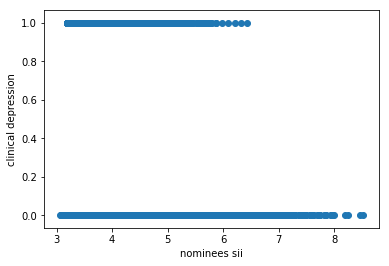

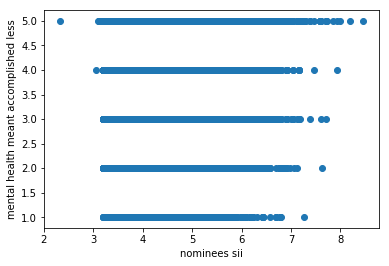

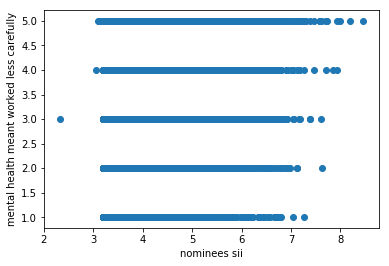

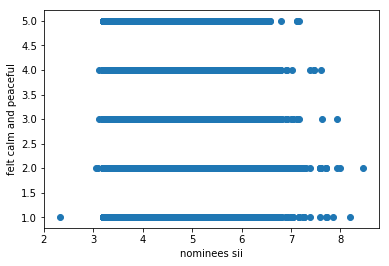

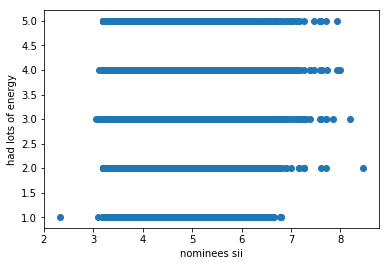

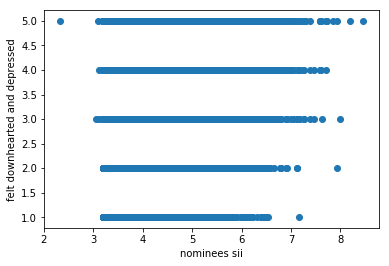

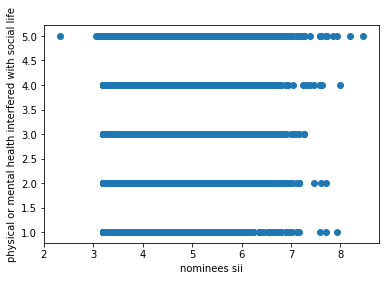

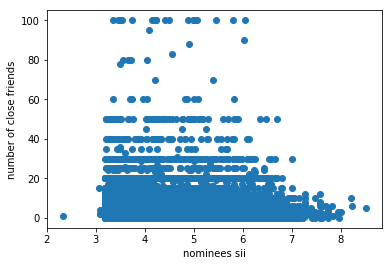

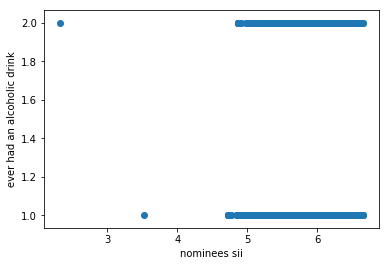

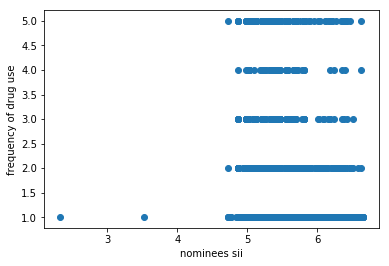

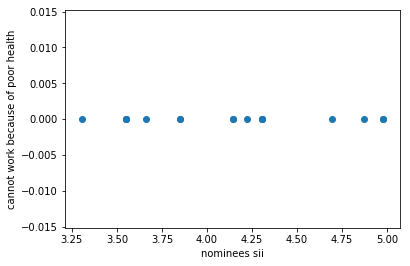

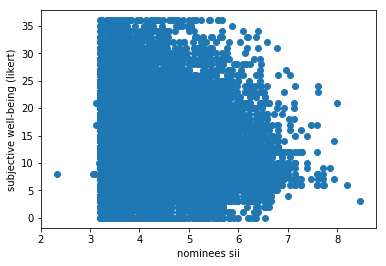

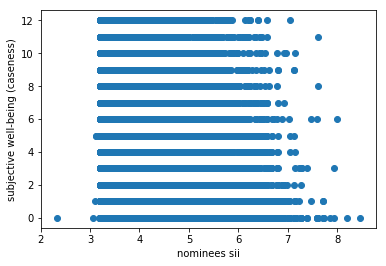

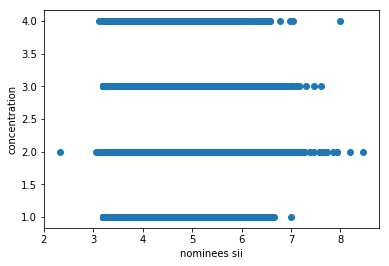

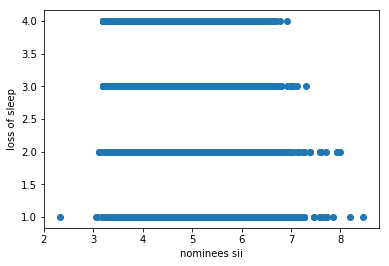

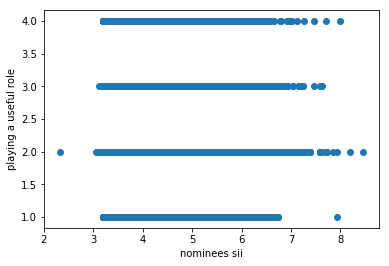

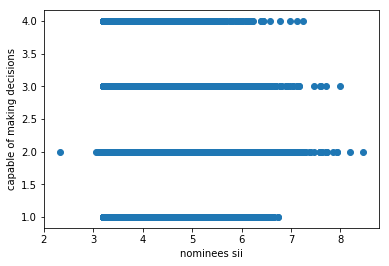

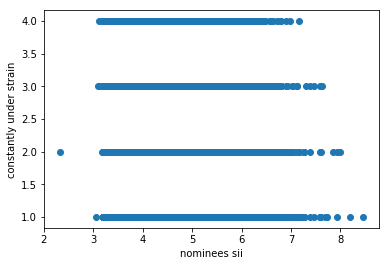

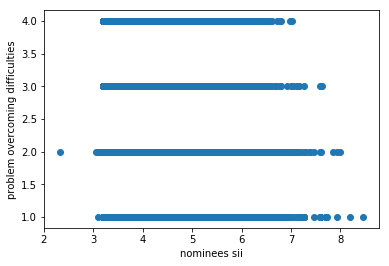

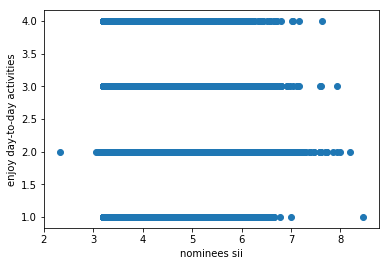

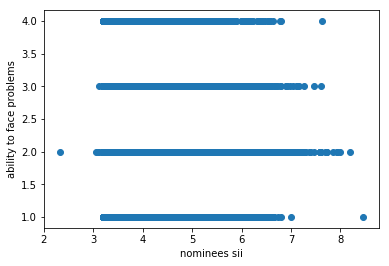

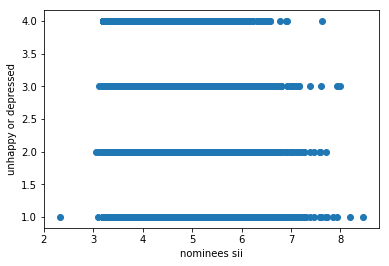

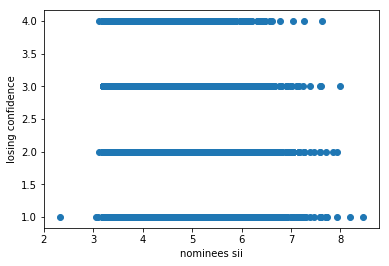

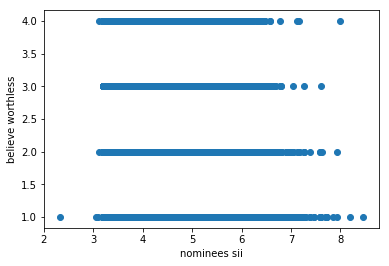

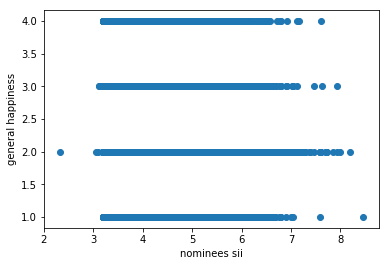

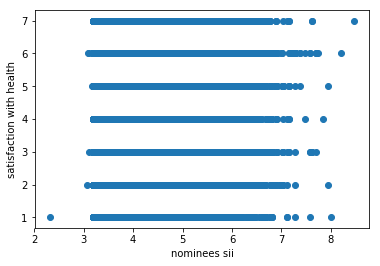

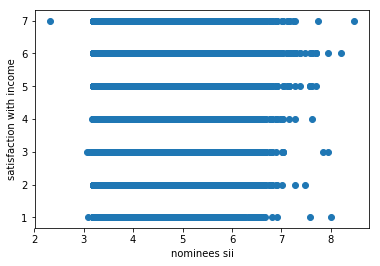

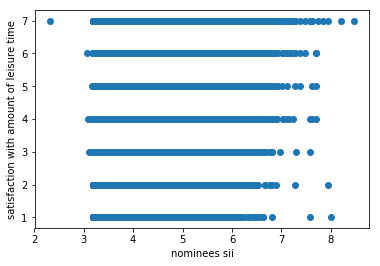

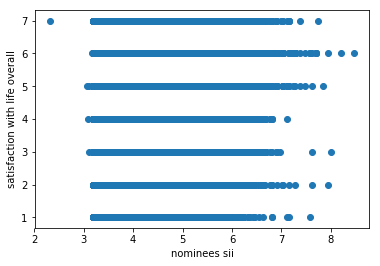

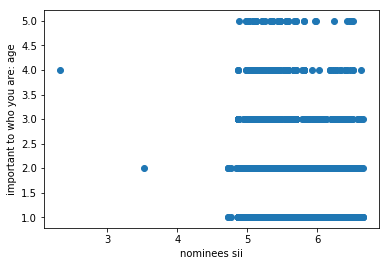

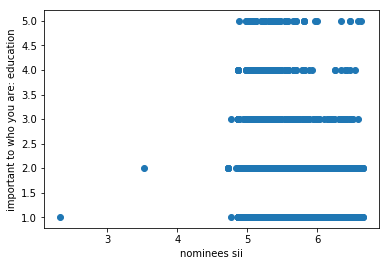

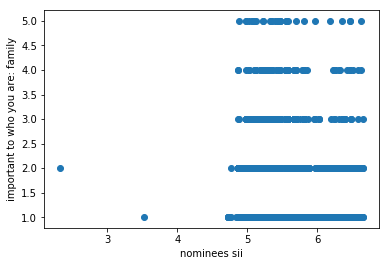

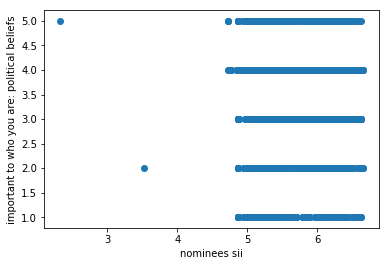

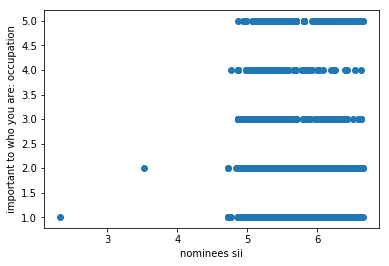

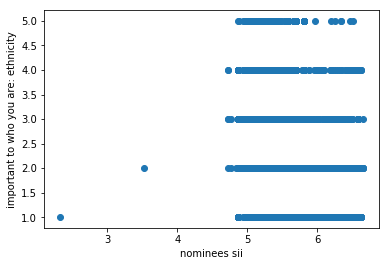

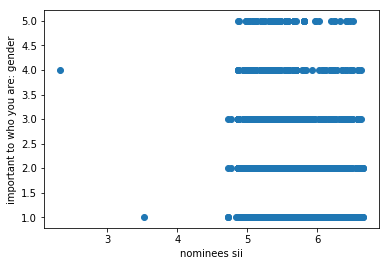

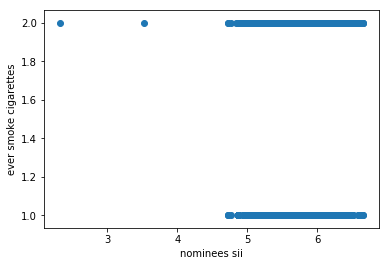

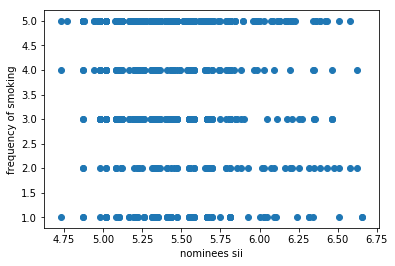

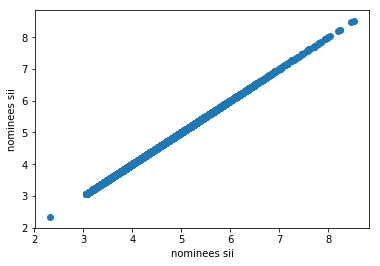

In [42]:
plot_data(ukhls_3_wellbeing, ukhls_3_nominees_sii)

Age is expected to be a key explanatory variable in such cases, so let us repeat the visualization with Age instead of SII.

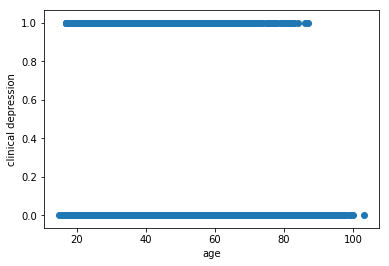

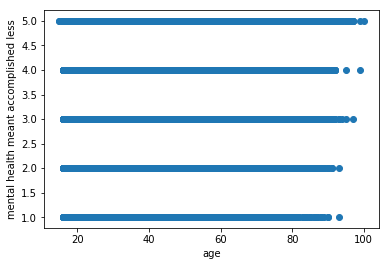

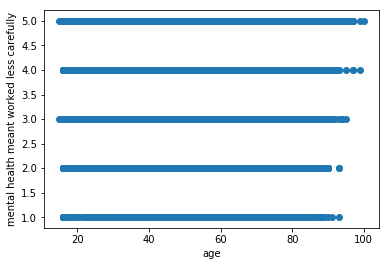

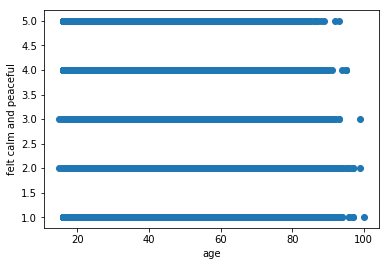

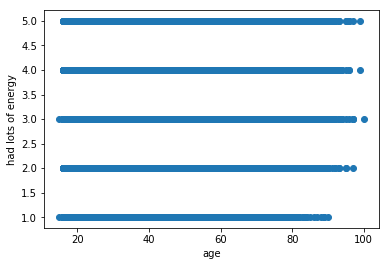

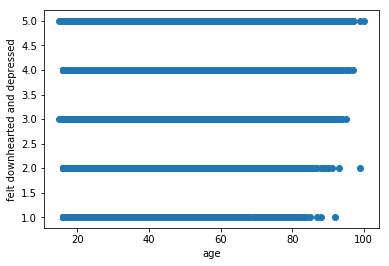

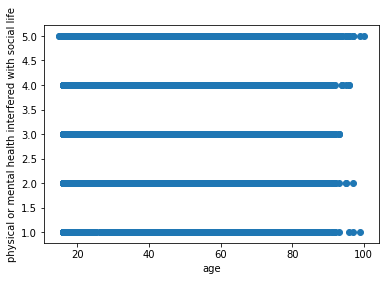

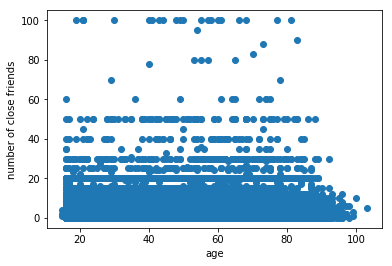

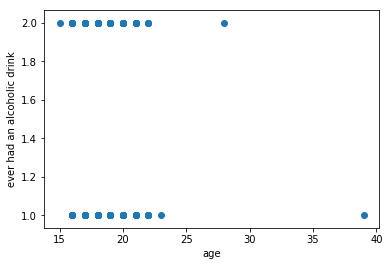

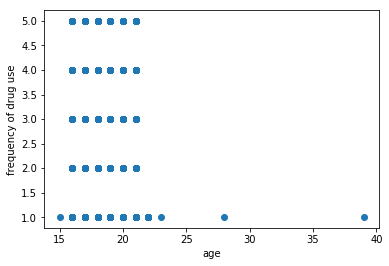

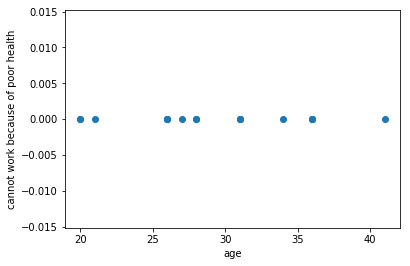

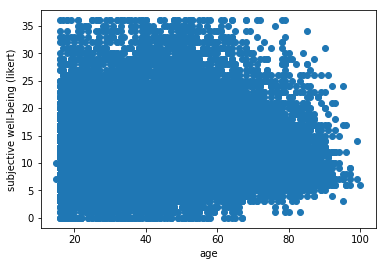

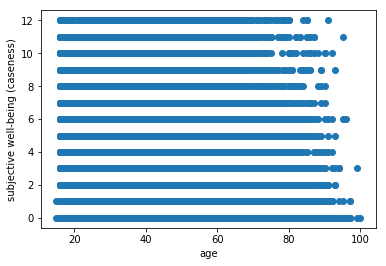

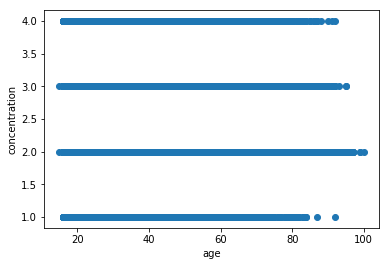

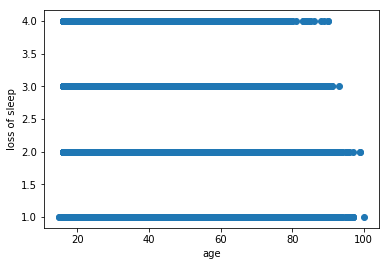

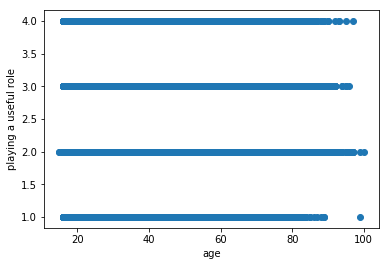

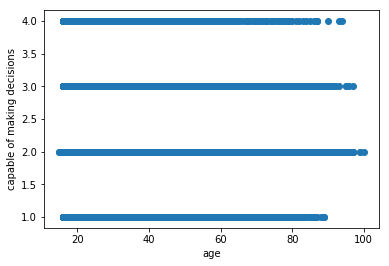

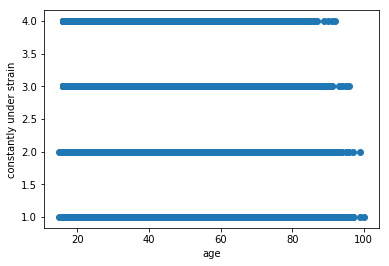

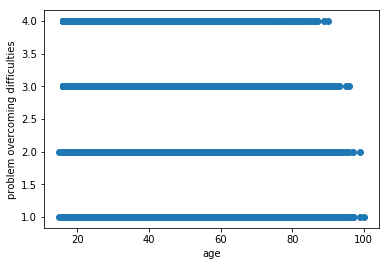

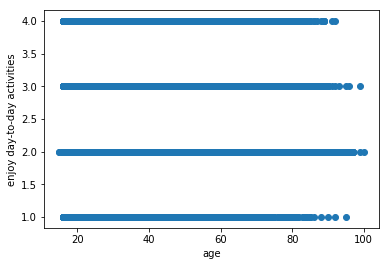

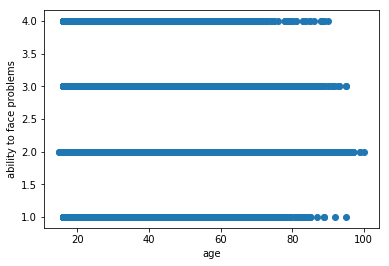

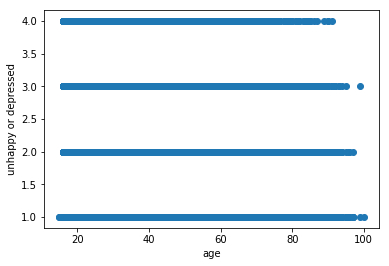

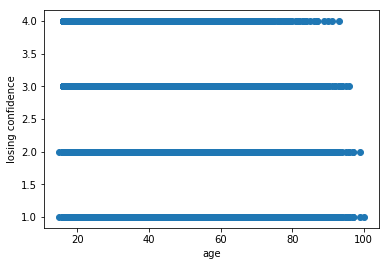

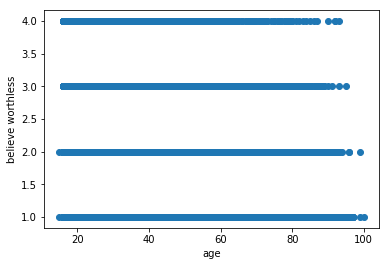

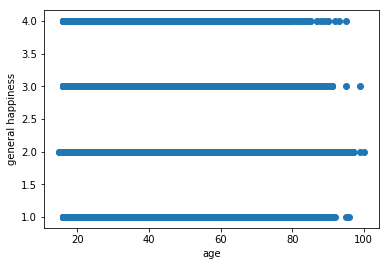

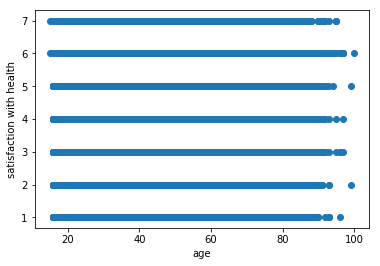

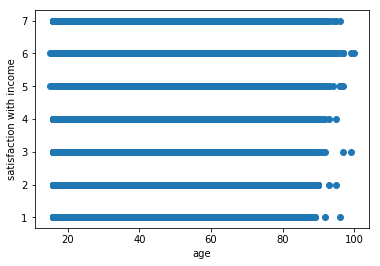

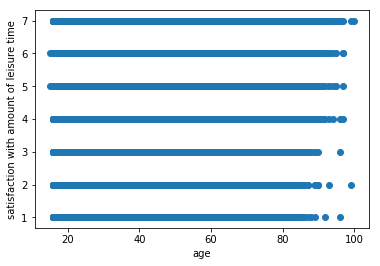

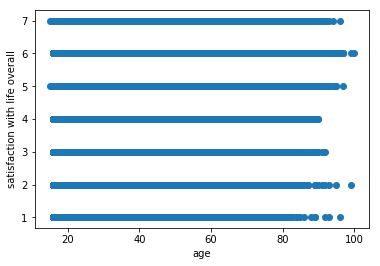

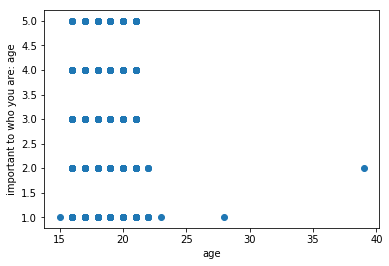

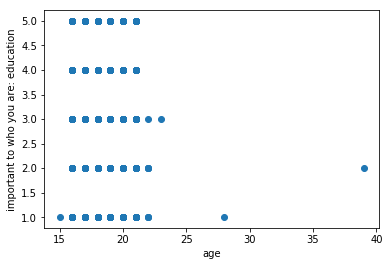

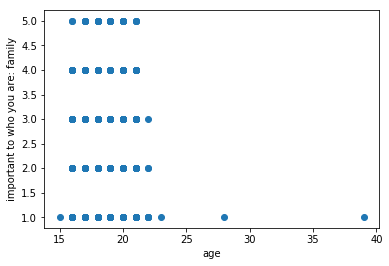

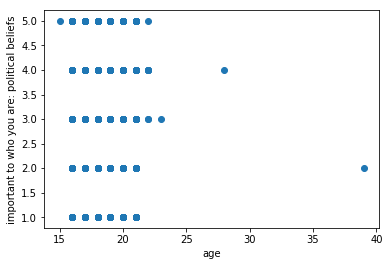

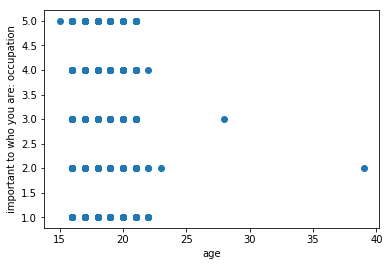

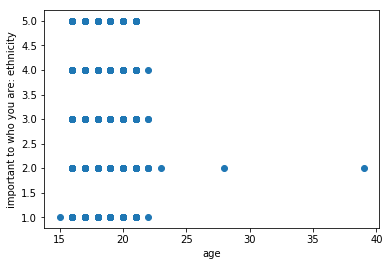

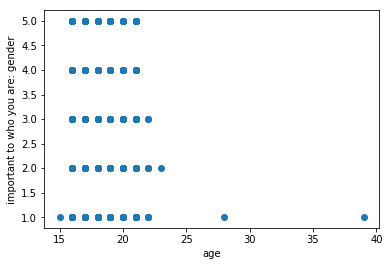

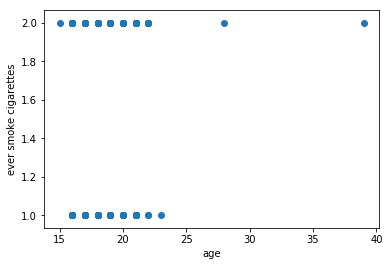

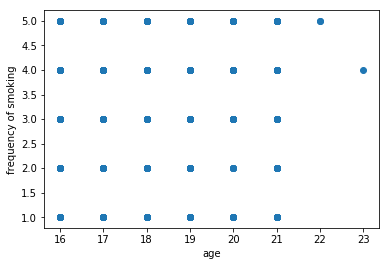

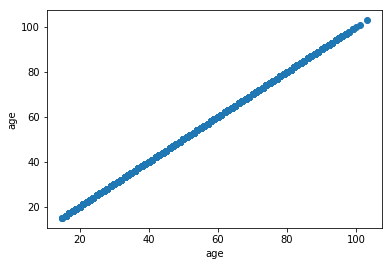

In [50]:
plot_data(ukhls_3_wellbeing, ukhls_3_nominees['age'])

#### Relation to Physical Health Outcomes

There is no apparent relationship between individual SII and physical health indicators.

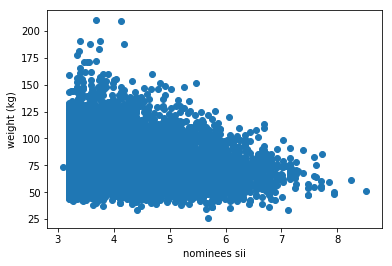

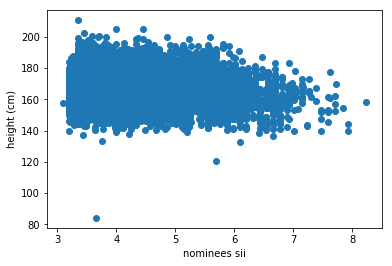

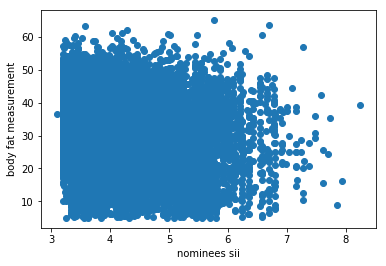

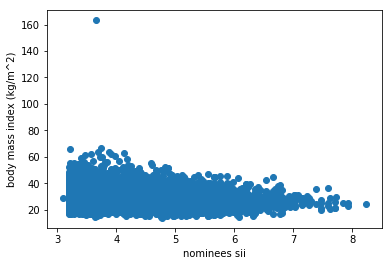

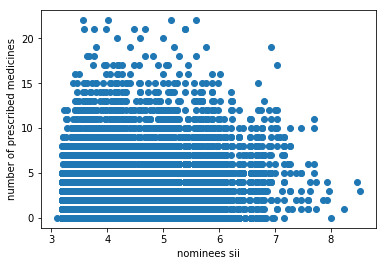

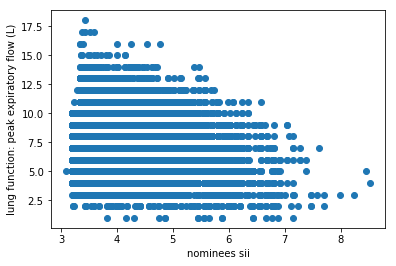

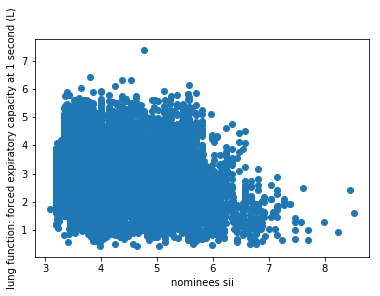

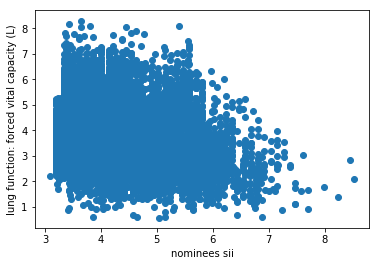

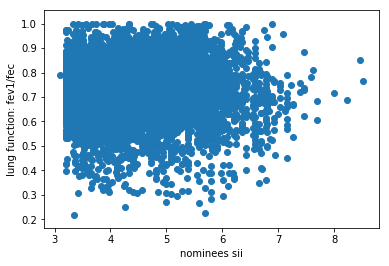

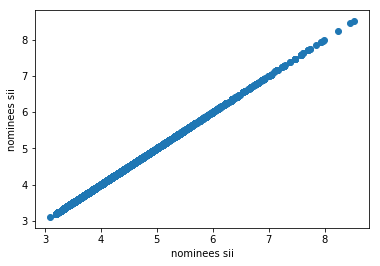

In [51]:
plot_data(nurse_health, ukhls_3_nominees_sii)

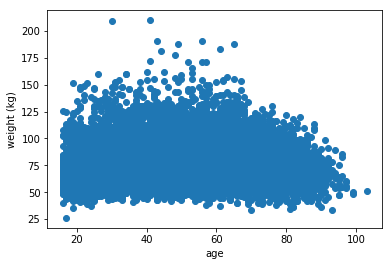

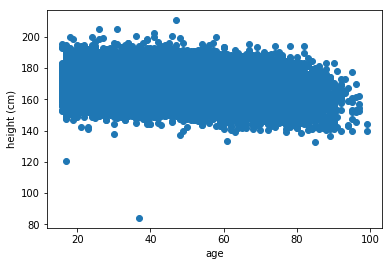

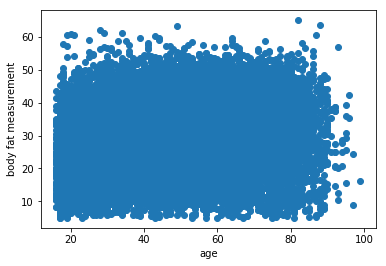

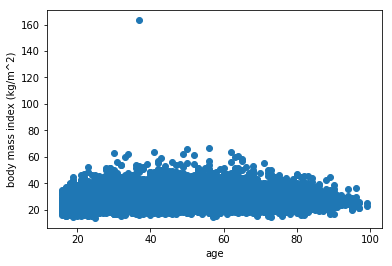

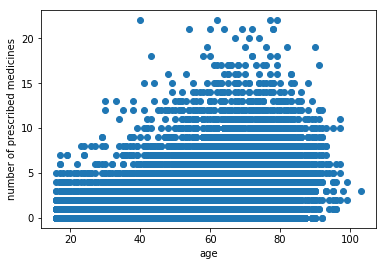

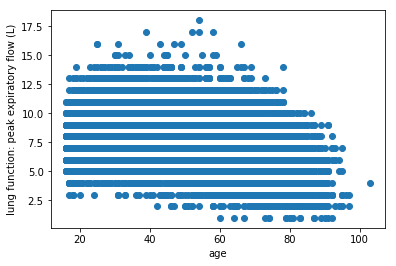

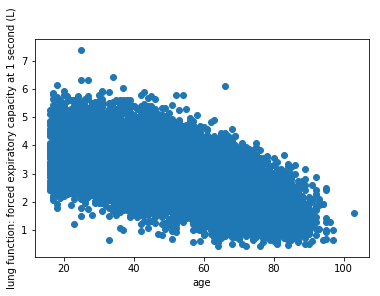

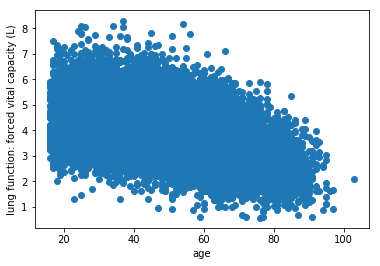

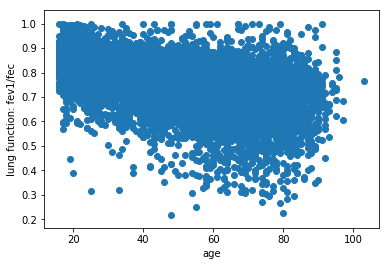

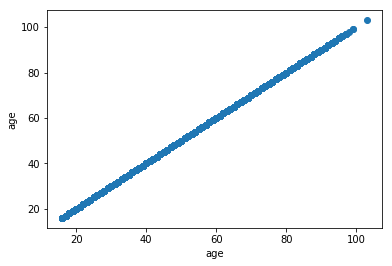

In [52]:
plot_data(nurse_health, ukhls_3_nominees['age'])

#### Relationship to Biological Markers

There seem to be some apperent patterns, in particular with 
1. [Insulin-like growth factor 1](https://en.wikipedia.org/wiki/Insulin-like_growth_factor_1), a growth hormone
2. [Didehydroepiandrosterone Sulphate](https://en.wikipedia.org/wiki/Dehydroepiandrosterone_sulfate), a neurosteroid
3. [Cholestrol](https://en.wikipedia.org/wiki/Insulin-like_growth_factor_1)
4. [Gamma Glutamyltransferase](https://en.wikipedia.org/wiki/Gamma-glutamyltransferase), an enzyme found in the liver and associated with liver disease
5. [Glycated haemoglobin](https://en.wikipedia.org/wiki/Glycated_hemoglobin) which is associated with the blood sugar levels

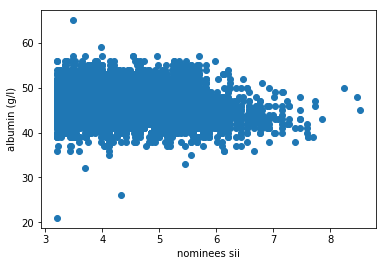

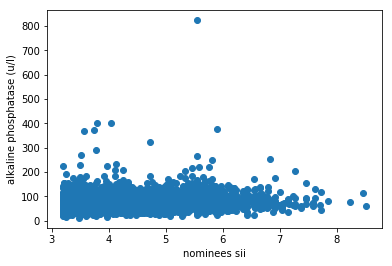

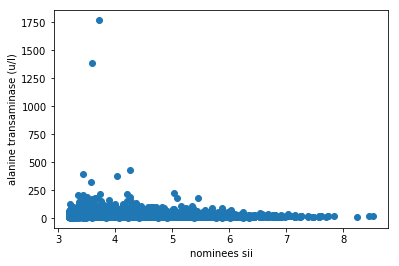

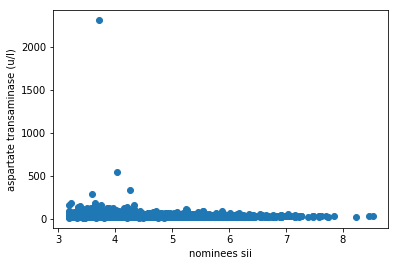

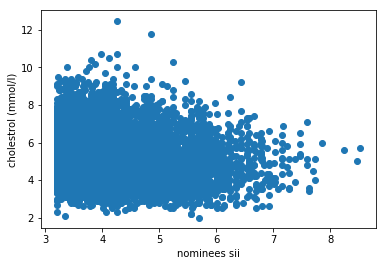

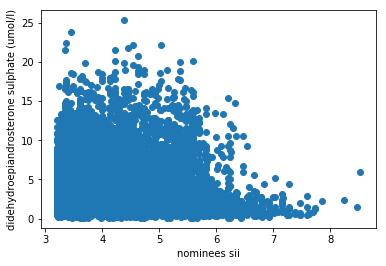

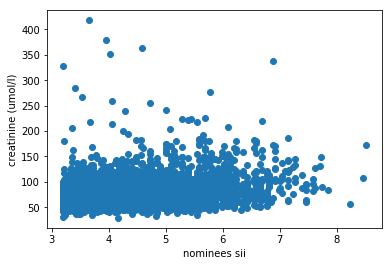

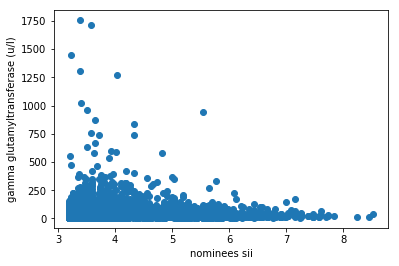

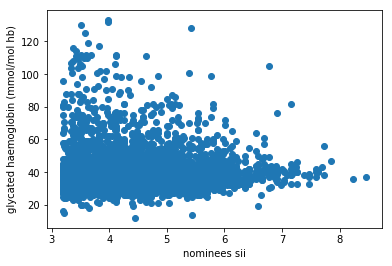

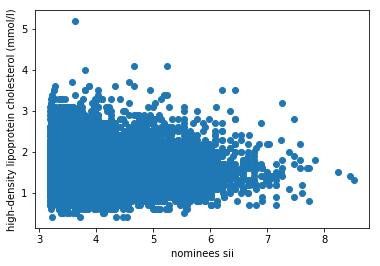

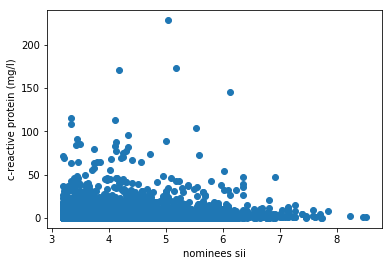

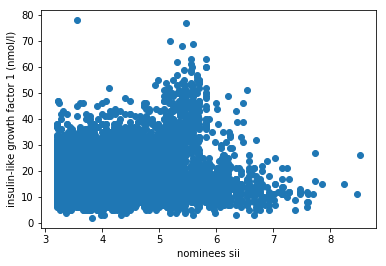

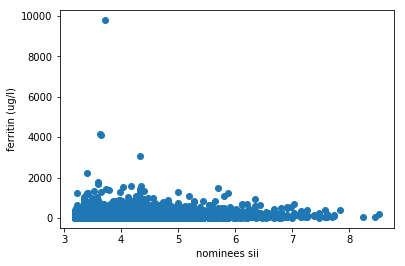

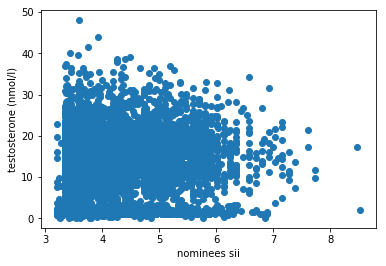

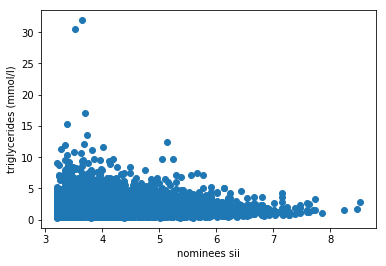

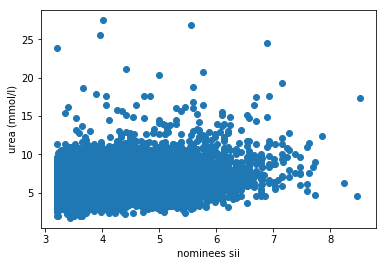

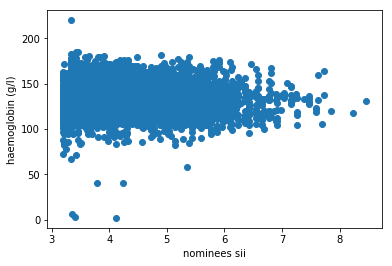

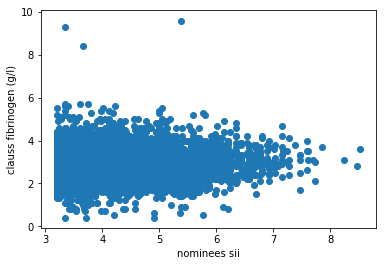

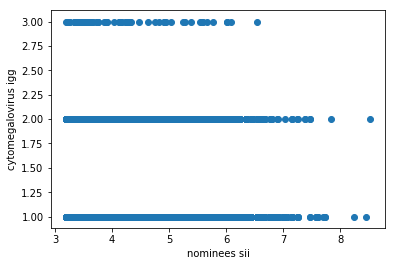

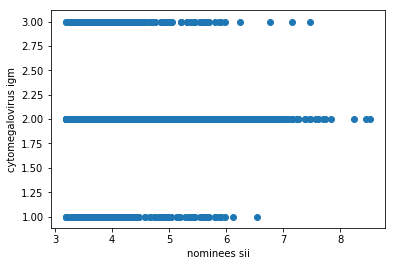

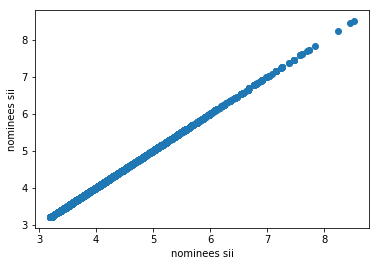

In [53]:
plot_data(nurse_biomarkers, ukhls_3_nominees_sii)

All of these are potentially directly affected by age, which happens to be an important contributer to individual-SII. However, age might just be a "better" explanatory variable for these biomarkers. As before, let us look at that by visualizing them against the age variable.

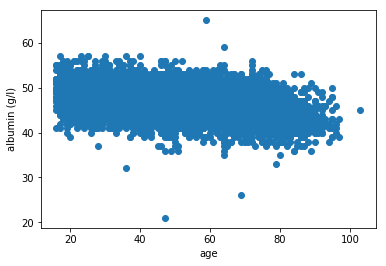

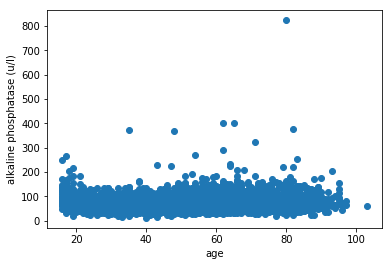

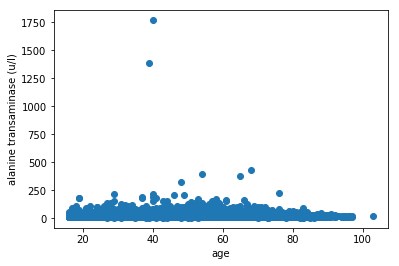

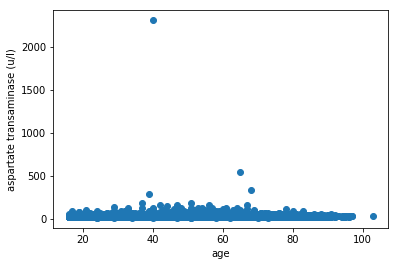

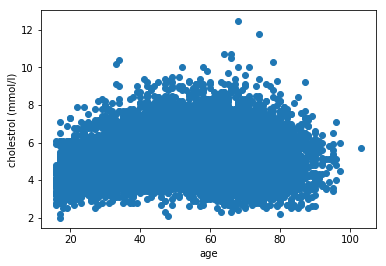

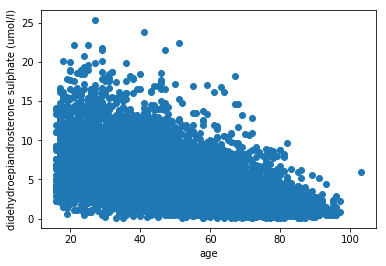

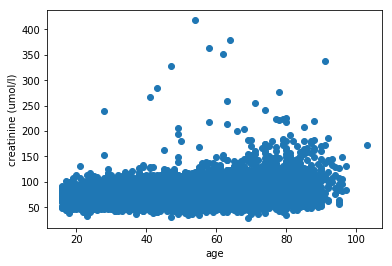

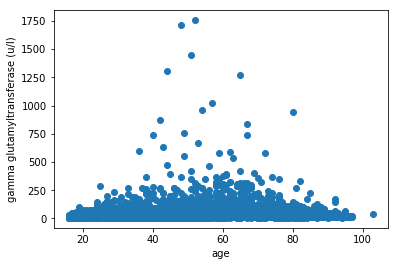

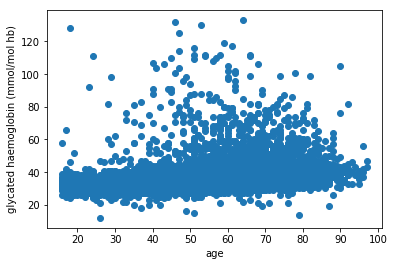

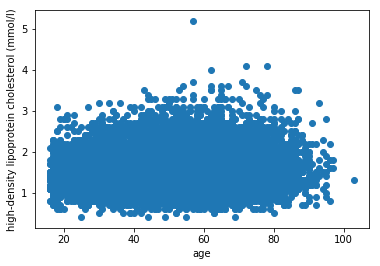

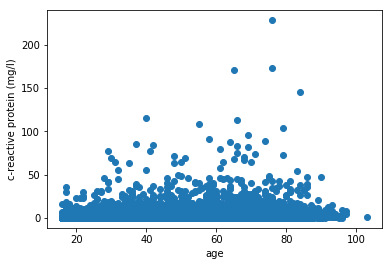

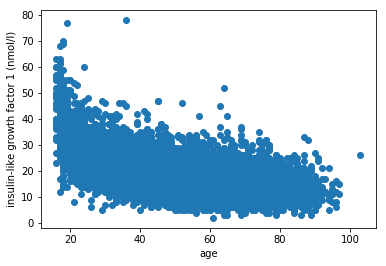

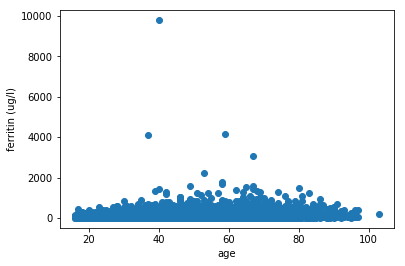

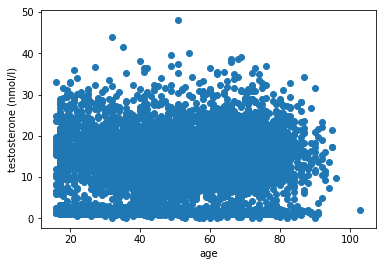

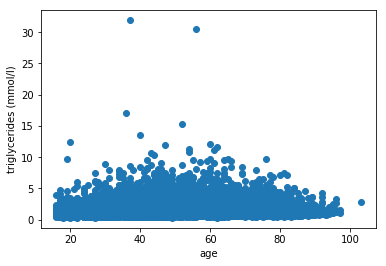

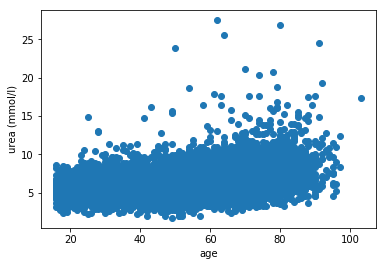

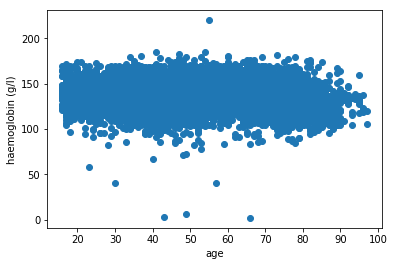

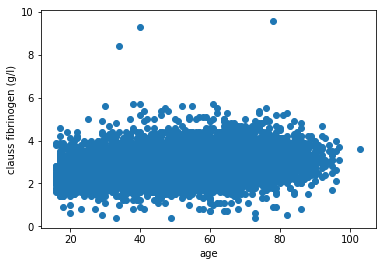

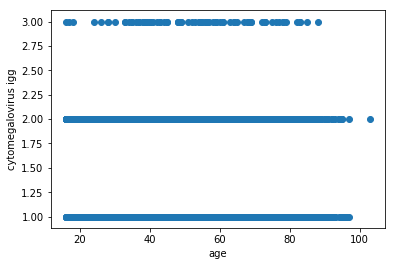

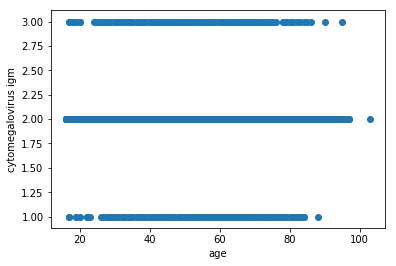

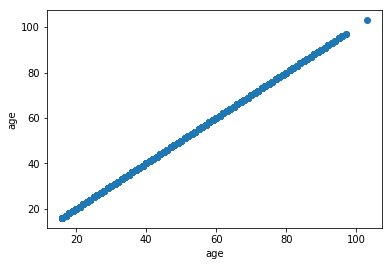

In [54]:
plot_data(nurse_biomarkers, ukhls_3_nominees['age'])

## Bonus

In reference to the link between inflammation and wellbeing that Sumeet shared, a quick visualization on CRP levels associated with inflammation to self-reported wellness.

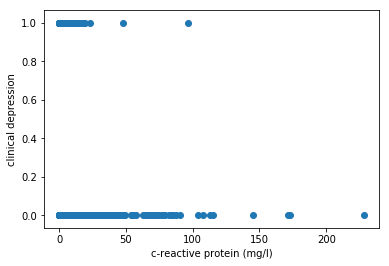

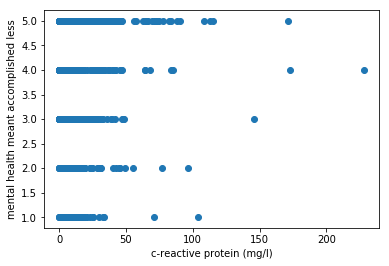

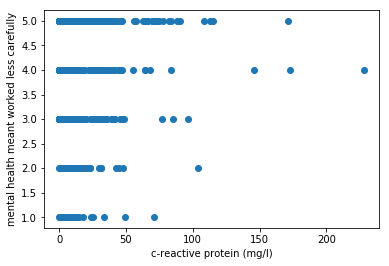

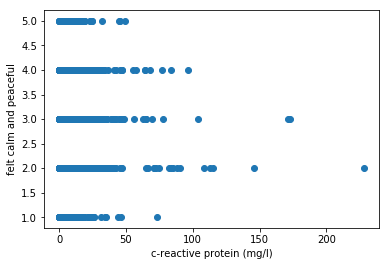

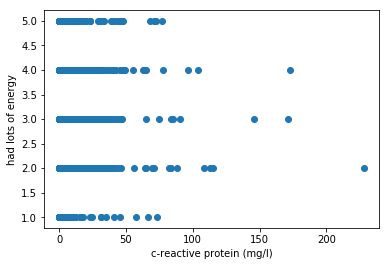

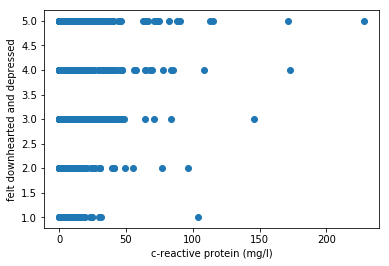

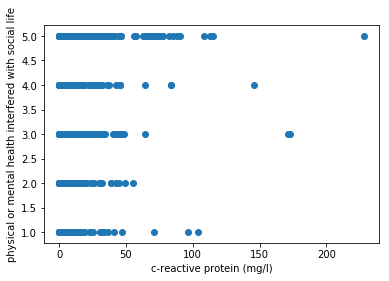

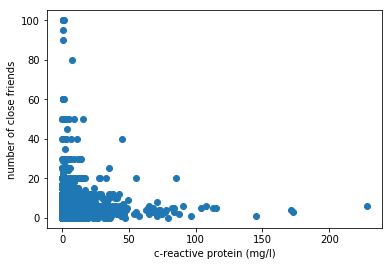

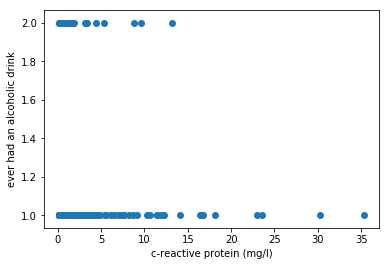

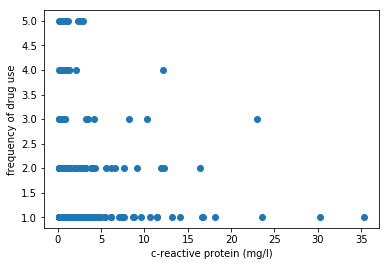

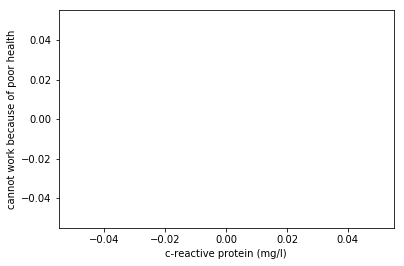

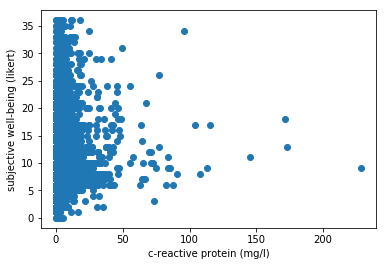

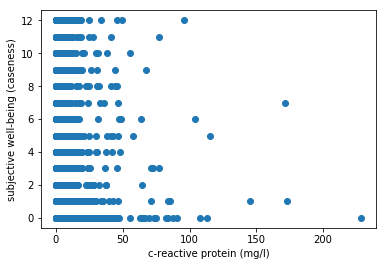

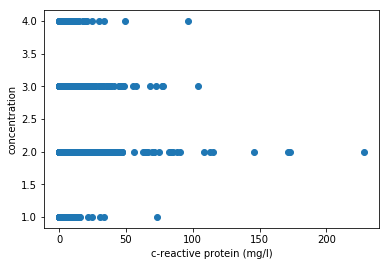

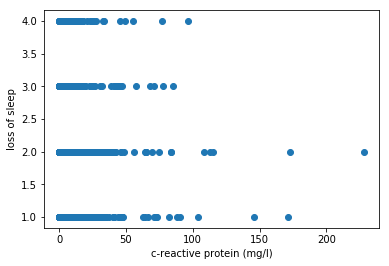

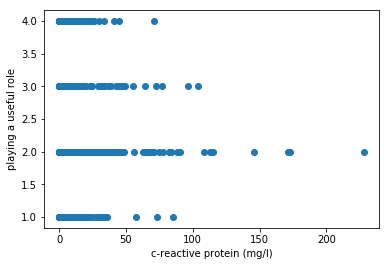

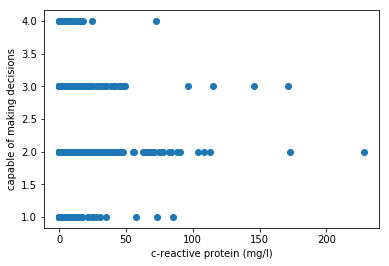

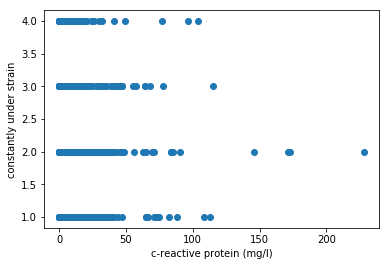

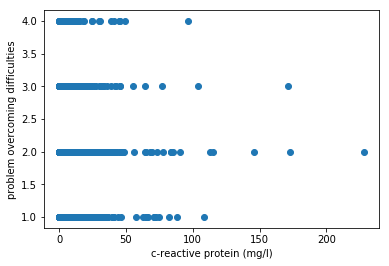

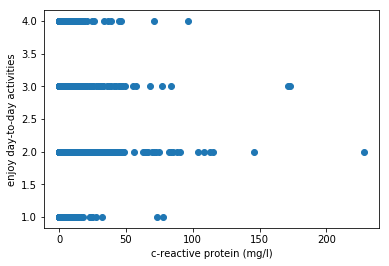

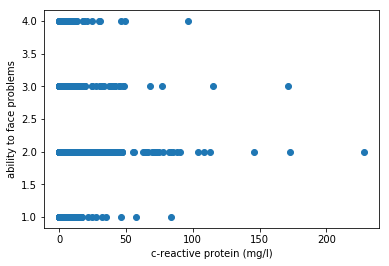

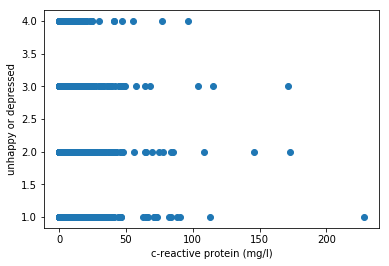

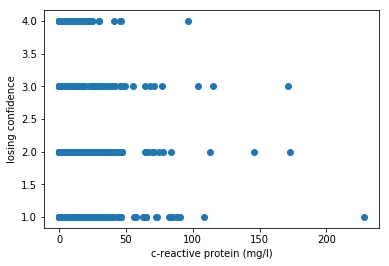

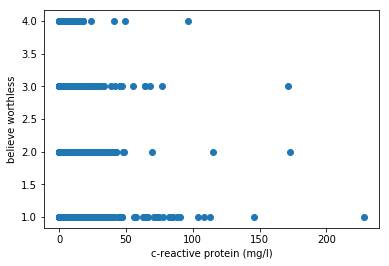

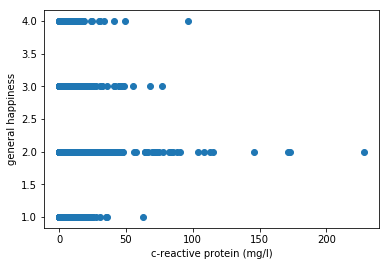

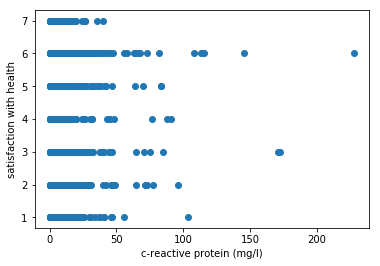

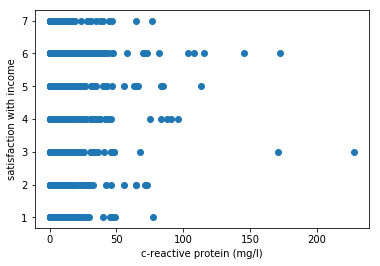

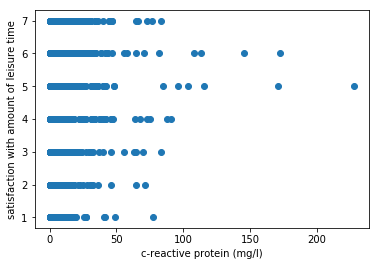

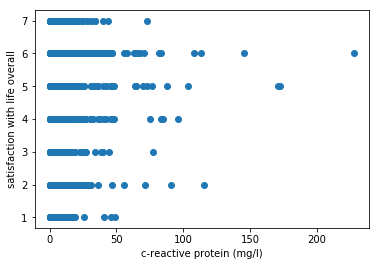

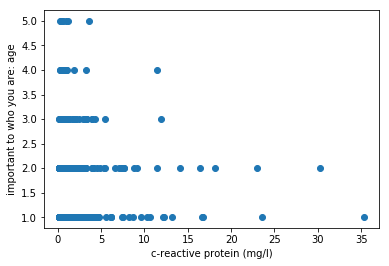

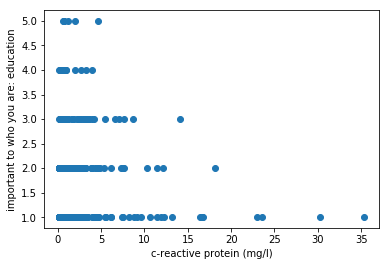

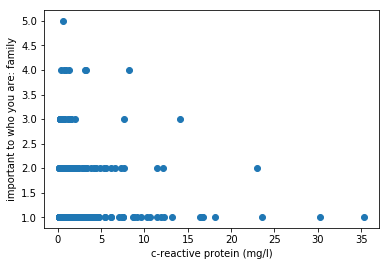

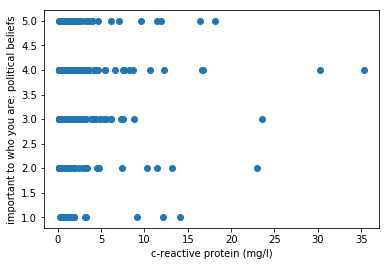

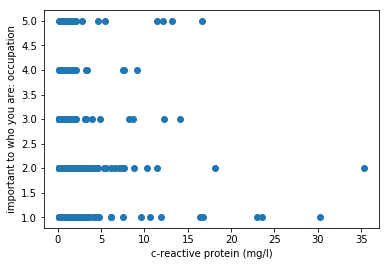

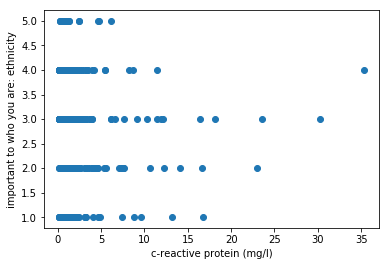

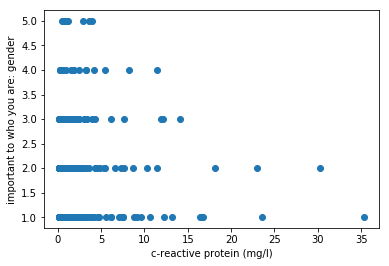

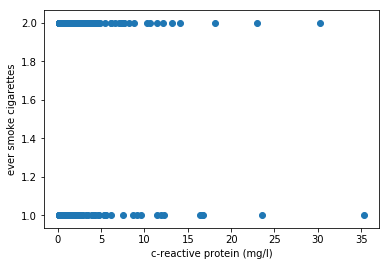

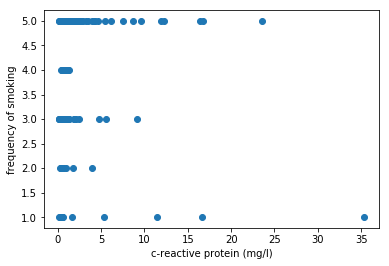

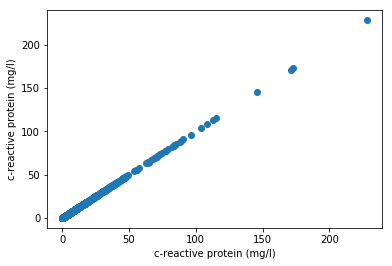

In [55]:
plot_data(ukhls_3_wellbeing, nurse_biomarkers['c-reactive protein (mg/l)'])

# A Converse Interpretation of the Connectivity Kernel

Without loss of generality, consider the probabilistic connectivity kernel in a 1-dimensional categorical Blau space with $k$ communities, that is $x_i \in \{1,2,...,k\} \forall i \in n$. The objective of kernel inference is to find $$P(a_{ij}=1|x_i,x_j)$$ where $a_{ij}$ indicates if individual $i$ is connected to individual $j$. According to the kernel under consideration, $$P(a_{ij}=1|x_i,x_j) = \sigma (\phi + \theta|x_i\neq x_j|)$$ where $\sigma$ is the logistic function.

## Bayes Rule to the Rescue
Let us consider a converse decomposition of the connectivity kernel. We can express the joint distribution of Blau coordinates and the adjacency indicators in two ways by changing the conditioned variables, as below:
\begin{equation}
\begin{split}
P(a_{ij}=1,x_i,x_j) &= P(x_j|x_i,a_{ij}=1) * P(x_i) * P(a_{ij}=1)\\
&= P(a_{ij}=1|x_i,x_j) * P(x_i) * P(x_j)
\end{split}
\end{equation}

Thus, the connectivity kernel can be rewritten as:
$$P(a_{ij}=1|x_i,x_j) = \frac{P(x_j|x_i,a_{ij}=1)}{P(x_j)} * P(a_{ij}=1)$$

Let us take a logit of the above expression. If the edge density $P(a_{ij}=1)$ is very low, the logit function approximates the log, and thus on combining this with the original connectivity kernel we obtain
$$\log(P(a_{ij}=1)) + \log\left(\frac{P(x_j|x_i,a_{ij}=1)}{P(x_j)}\right) = \phi + \theta|x_i\neq x_j|$$

Therefore, we obtain a very clear correspondence between $\phi$ of the original model and the edge density $P(a_{ij}=1)$. We would like to establish a full correspondence with the original kernel. For that, let us further assume that if $x_i = \mathcal{X} = x_j$, then $i$ will not discriminately connect with $j$, that is $P(x_j = \mathcal{X}|x_i=\mathcal{X},a_{ij}=1) = P(x_j = \mathcal{X})$, and if $x_i = \mathcal{X} \neq x_j$, then $i$ will equally discriminate against all groups $\{1,2,...,k\}-\{\mathcal{X}\}$, that is $$\frac{P(x_j=\chi|x_i=\mathcal{X},a_{ij}=1)}{P(x_j=\chi)} = \exp(\theta) \quad\quad\forall \chi \in \{1,2,...,k\}-\{\mathcal{X}\}$$

Evaluating this for all possible $\chi$, summing them up, and noting the complementarity of our partitions, we obtain:
$$\frac{1-P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}{1-P(x_j=\mathcal{X})} = \exp(\theta) \quad\quad\forall \chi \in \{1,2,...,k\}-\{\mathcal{X}\}$$

But from the first assumption, this just gives us $\theta=0$. Which means that if $i$ doesn't discriminately connect to people of its own community, and equally discriminates against people of any another community, then $i$ does not discriminate at all. The original kernel cannot account for a true sense of discrimination. (In some sense, $\phi$ isn't truly a Blau-agnostic edge density term.) Let us modify the kernel definition such that

$$P(a_{ij}=1|x_i,x_j) = \sigma (\hat{\phi} + \hat{\theta}|x_i\neq x_j|)$$

Where $\hat{\phi} = \phi + \alpha$ and $\hat{\theta} = \beta - \alpha$ are "apparent" edge density and "apparent" homophily. Now repeating the above analysis, the assumption becomes that $i$ discriminately connects to people of its own community by a factor of $\alpha$, and of another by a factor of $\beta$, where 

\begin{equation}
\begin{split}
\alpha &= \log\left(\frac{P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}{P(x_j=\mathcal{X})}\right) \\
\beta &= \log\left(\frac{1-P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}{1-P(x_j=\mathcal{X})}\right) \\
\hat{\theta} &= \log\left(\left(\frac{P(x_j=\mathcal{X})}{1-P(x_j=\mathcal{X})}\right)\left(\frac{1-P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}{P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}\right)\right) \\
\hat{\phi} &= \log\left(P(a_{ij}=1)\frac{P(x_j=\mathcal{X}|x_i=\mathcal{X},a_{ij}=1)}{P(x_j=\mathcal{X})}\right)
\end{split}
\end{equation}

Note that we still have a conditioning on $x_i=\mathcal{X}$. However, the original kernel does not consider community-specific parameters. We can obtain an overall "tied" set of parameters for a better comparison to the original kernel. For that we must assume these parameters $\alpha$ and $\beta$ are the same for all communities. It can be straightforwardly shown using the fact that $\sum_{\kappa \in \{1,2,...,k\}}P(x_i=\kappa)=1$ that these parameters are

\begin{equation}
\begin{split}
\alpha &= \log\left(\sum_\kappa P(x_j=\kappa|x_i=\kappa,a_{ij}=1)\right) \\
\beta &= \log\left(\frac{k-\sum_\kappa P(x_j=\kappa|x_i=\kappa,a_{ij}=1)}{k-1}\right) \\
\hat{\theta} &= \log\left(\frac{\frac{k}{\sum_\kappa P(x_j=\kappa|x_i=\kappa,a_{ij}=1)}-1}{k-1}\right) \\
\hat{\phi} &= \log\left(P(a_{ij}=1)\sum_\kappa P(x_j=\kappa|x_i=\kappa,a_{ij}=1)\right) 
\end{split}
\end{equation}

It is consistent to furthermore assume that every community discriminately prefers its company over that of others irrespective of which community we talk of. That is, $P(x_j=\kappa|x_i=\kappa,a_{ij}=1) = \rho \forall \kappa \in \{1,2,...,k\}$. Let $P(a_{ij})=\omega$. Effectively, this leads us back to a situation with exactly two model parameters, as we had them before in the original kernel, described as below:

\begin{equation}
\begin{split}
\alpha &= \log\left(k\rho\right) \\
\beta &= \log\left(\frac{1-\rho}{1-\frac{1}{k}}\right) \\
\hat{\theta} &= \log\left(\frac{\frac{1}{\rho}-1}{k-1}\right) \\
\hat{\phi} &= \log\left(\omega k\rho\right) 
\end{split}
\end{equation}

### Things to Note
Let us note some interesting things about this kernel definition:
1. The interpretation of $\rho$ is particularly straightforward; it is simply the average proportion of friends one has of the same community. It is thus rather easy to estimate from survey data which only asks questions such as *"what proportion of your friends are from the same community (say ethnicity) as you?"*
2. The interpretation of $\omega$ is now as a "pure" Blau-agnostic edge density estimate. For a complete undirected network of $n$ nodes and $m$ edges with no self-loops, it is simply $\frac{2m}{n(n-1)}$. For an incomplete graph, as long as we are not explicitly interested in average edge densities, we can simply ignore $\omega$ (as we'll see for social isolation index).
3. $k$ is mostly a fixed constant, possibly based on a design-choice, that defines how many distinct groups or communities exist in this Blau dimension.
4. We have managed to decouple the effects of choice and structural homophily in the above model description. This becomes rather clear when we note that $\rho$ is a completely individual (or community)-choice driven behaviour, while $k$ is a structural artifact of societal composition. (This becomes more evident in the more generalized definitions of the parameters above.) Thus, say if $\rho$ is too large, then for the same $k$, the apparent homophily $\hat{\theta}$ will be highly negative. Alternately, for the same $\rho$, keeping a small $k$ reduces the apparent homophily. 
5. We have made a sequence of assumptions to conclude that the proposed model is equivalent to the original model. In general, none of these assumptions need to be there. Indeed, we can assume $\rho_{ij}$, which signifies the proportion of friends of people in the $i$th community that are in community $j$, and estimate these for all pairs of communities. This leads to a [stochastic block model](https://en.wikipedia.org/wiki/Stochastic_block_model) (SBM). These models assume a community structure in the network, which goes beyond the conditional independent edge model (CIEM) assumptions. In essence, one can relax the assumptions made by the CIEM "in reverse" to reach an SBM, and the above is an effort in that. ($\omega\alpha$ and $\omega\beta$ are parameters $p$ and $q$ of a planted partition model.)
6. Note how the "apparent" edge density $\hat{\phi}$ is actually the coupling of all 3 parameters+constant of the model, while "apparent" homophily is a coupling of the 2 parameters.

## Social Isolation Index

As before, we define the pairwise SII to be $\psi(x_i=\mathcal{X},x_j=\chi) = -\log\frac{P(a_{ij}=1|x_i=\mathcal{X},x_j=\chi)}{P(a_{ij}=1|x_i=x_j=\mathcal{X})}$. Making all of the assumptions we did above, we obtain

\begin{equation}
\begin{split}
\psi(x_i=\mathcal{X},x_j\neq x_i) &= -\log\left(\frac{\exp(\beta)}{\exp(\alpha)}\right) \\
&= -\log\left(\frac{\frac{1}{\rho}-1}{k-1}\right)
\end{split}
\end{equation}

Recall from above that the definition for apparent homophily $\hat{\theta}$ was exactly the negative of this pairwise social isolation index. In his thesis, Till noted a similar equivalence of the model parameter $\theta$ to SII under the assumption of sparsity. We now obtain an exact equivalence between apparent homophily $\hat{\theta}$ and SII, without calling for the assumption of sparsity. (The assumption of sparsity is needed only later, to correspond $\hat{\theta}$ with the original kernel formulation.) The definition of individual-level SII follows as for the original kernel formulation. That is,

\begin{equation}
\begin{split}
\widetilde{\psi}(x_i=\mathcal{X}) &= \sum_\kappa \psi(x_i=\mathcal{X}, x_j\neq x_i) P(x_j=\kappa)\\
&= \psi(x_i=\mathcal{X}, x_j\neq x_i) * (1-P(x_i))
\end{split}
\end{equation}

Assuming an equiproportion composition of the "test" population, this reduces to $-\log\left(\frac{\frac{1}{\rho}-1}{k-1}\right)\left(1-\frac{1}{k}\right)$.

In the second line, we are able to take $\psi$ out since under the current assumptions it is independent of the "other" community. However in the general SBM setting, this may not be true. Similarly, we can integrate over $x_i$ to obtain the global segregation measure.

$$\Phi = \psi(x_i=\mathcal{X}, x_j\neq x_i) * \sum_\kappa P(x_i=\kappa)(1-P(x_i=\kappa))$$

Assuming an equiproportion composition of the "test" population, this reduces to $-\log\left(\frac{\frac{1}{\rho}-1}{k-1}\right)\left(1-\frac{1}{k}\right)$.

## Parameter Estimation

As already noted above, estimating $\omega$ is straightforward. Estimating $\rho$ is also much easier than computing $\theta$ via Bayesian inference using MCMC.

Consider the following generative process. For every seed $x_i$, consider that their friend $x_j$ will belong to the same community with probability $\rho$, and to a different community with probability $1-\rho$. This is akin to a bias coin toss. Thus if we know the following things for every person $x_i$:

1. How many friends they have: $n(i)$
2. What proportion of their friends are from "same community": $\rho(i)$

Then one can generate "training data" corresponding to $n(i)*\rho(i)$ heads (H) and $n(i)*(1-\rho(i))$ tails (T). Then parameter estimation is as easy as counting the number of heads and tails. Assuming a $\mathrm{Beta}$ prior on $\rho$ with parameters $\alpha_\rho, \beta_\rho$, we can obtain a MAP estimate:

$$\rho_{\mathrm{MAP}} = \frac{|H|+\alpha_\rho}{|H|+|T|+\alpha_\rho+\beta_\rho}$$

This is certainly much faster to compute than performing MCMC.

## Extending to Multiple Blau Dimensions

The above framework naturally extends to multiple categorical Blau dimensions $\mathbb{B}^D$. Assuming the distribution factorizes over Blau dimensions, we would obtain a direct correspondence to the original kernel formulation with deparate homophilies $\theta_d$ for dimension $d \in \mathbb{D} = \{1,2,...,D\}$. Thus, we have the following:

\begin{equation}
\begin{split}
\alpha_d &= \log\left(k_d\rho_d\right) \\
\beta_d &= \log\left(\frac{1-\rho_d}{1-\frac{1}{k_d}}\right) \\
\hat{\theta_d} &= \log\left(\frac{\frac{1}{\rho_d}-1}{k_d-1}\right) \\
\hat{\phi} &= \log\left(\omega\prod_d k_d * \rho_d\right) 
\end{split}
\end{equation}

In the SBM setting, instead of a $k\times k$ probability matrix, we now have a $\prod_d k_d \times \prod_d k_d$ matrix. Since the dimensions are assumed to be independent, we can succinctly write $P$ using the Kroenecker product as:
$$ P = P_1 \otimes P_2 ... \otimes P_D$$

However, we might like to generalize this matrix. Let us partition the Blau space into $\mathbb{Q}$, such that every element $Q\in \mathbb{Q}$ represents a set of co-dependent Blau dimensions. (Say income and employment might be put in the same set.) We can define probability matrices for every element in the partition so
$P_Q$ is some $\prod_{q\in Q} k_q \times \prod_{q\in Q} k_q$ matrix such that:

$$ P = \bigotimes_{Q\in\mathbb{Q}} P_Q$$


### Constraints of Real Survey Data

Generalizing to dependent Blau dimensions is, as described above, not technically tricky given the SBM description. However, it is difficult to ask a single respondent about the proportion of their friends which belong to each other community of a particular Blau dimension. Often, it's just easier to ask and for the respondent to answer "how many of you friends are of *a* different community?" And of course, we can always ask the respondent which community *they* belong to. Thus, $P_{ii}$s are available, while $P_{ij}$s are not. This means we are limited to a slightly more complex version of the planted partition model, wherein the diagonal elements are given by $P_{ii}$, and off-diagonal by $\frac{P_{ii}}{k-1}$. However, with the added assumption that the matrix is symmetric, that is members of community $i$ will connect to those of $j$ with the same propensity as in the opposite direction, we can symmetrisize the matrix appropriately such that off_diagonal elements 

$$P_{ij} = P_{ji} = \frac{1-\frac{P_{ii}+P_{jj}}{2}}{k-1}$$

Similarly, extending to many dimensions, we first write:

$$P_{(i_1,i_2\ldots i_{|Q|}),(j_1,j_2\ldots j_{|Q|})} = \prod_{m \in \{1,2\ldots |Q|\}} \left\{\left(P_{i_m,j_m}*|i_m=j_m|\right) + \left(\frac{1-P_{i_m,j_m}}{k_m-1}\right)*|i_m\ne j_m| \right\}$$

And then symmetrisize the matrix as $P=(P+P^T)/2$

## Possible Advantages of the Converse Connectivity Kernel

### Robustness to Missing Samples and Latent Dimensions
Since the converse kernel doesn't need any "control" edges, and it clearly decouples mean edge density $\omega$, it only needs information about "true" edges in the network, that too of their proportion. As long as seeds of a community show "similar" homophily to the average person of the community, a few hundred seeds might be enough to robustly estimate $\rho$.

Moreover, if there are any Blau dimensions which are unknown or missing, it would in no way affect the estimation of parameters for the observed dimensions. Clearly, this is not the case when we do multiple regression as in the regular forward kernel. One can imagine introducing a "perfectly discriminating" dimension which when included as one of the "predictors" will severely downweight the regression coefficients $\theta$ of previously observed dimensions. Or there can be issues of multi-collinearity that make the regression estimates unstable, which is fine for predictions but not good for independent interpretation of coefficients.

### Social Discriminatory Axes are Categorical
Note that the above proposed kernel has perhaps one unremediable weakness: it only works for categorical Blau dimensions, even in the most generalized SBM scenario. However on a closer look, we will appreciate that most social axes are categorical, and even if they are not are treated as such by social agents. Say, "age" is a continuous Blau dimension, however social agents do not evaluate "age" as such during tie-formation, but rather in broader classes of "young", "adult" and "senior". The restriction to categoricals can therefore be a blessing in disguise, since it is more cognitively plausible.

Additionally, when all variables are categorical, we can "truly" compare the "regression coefficients", or the apparent homophily values. Recall that earlier, we had to resort to tricks such as dividing the continuous variables by two standard deviations to make them comparable to categorical variables. However now, we do not have to perform any such tricks. But the burden now translates to the design of social surveys: *what is an appropriate "binning" of continuous variables which makes socio-cognitive sense?* This tantamounts to asking what a respondent would consider "similar" for that particular continuous Blau dimension. This question is important, as it directly impacts the number of groups $k$, and thus directly affects structural homophily.

An alternate question one might ask is, given the value of $\rho$, how many "groups" does a respondent assume for the given continuous parameter? For instance, we know from the USoc Data (see below) that for age, $\rho=0.75$. For a given apparent homophily estimate $\hat{\theta}$, one can write apparent $k$ as:
$$ k=1+(1/\rho -1)2^{-\hat{\theta}}$$

Say $\hat{\theta}=-5$, as discovered in the forward kernel by Till. Assuming sparsity, and that log is taken with respect to 2, this gives us an estimate $k\approx 12$. This gives us the granularity of discrimination of about 7 years, assuming adults from 16 to 100 years, which could have been a reasonable assumption to begin with. Furthermore for the American Life Panel (ALP) data, Till notes that Age is indeed collected over 15-year bins, which would correspond to $k\approx 6$. If we assume the same $\rho$ of Americans as of Britons, then the "apparent homophily" for age turns out to be $-3.9$, while Till reports a value of $-1.3$. So there is likely an underestimate of homophily in age.

Interestingly, the reported homophily in distance is large, $-5$, where distance is in terms of friends being in the same state or not. Conversely, we can infer $\rho$ for distance for given $k=52$ states of US, and $\hat{\theta}$ as:
$$\rho = (1+(k-1)2^{\hat{\theta}}))^{-1}$$

This gives an estimate of $\rho\approx 0.39$, that is roughly 2 in every 5 friends live in the same state of US. This appears comparably different to the $\rho$ for Britons, approximating at $0.55$ in the USoc Data where distance is in terms of living within 5 miles of one another, that is roughly 1 in every 2 friends lives within 5 miles in UK.

### Getting Rid of Dilution-type Effects

For the APL survey, Till notes in his thesis that age was not observed to be as homophilous as it was in other surveys like USoc. He attributes this to the dilution effect, noting that ages were rounded off to the dearest decade or so for the APL survey, which "reduced" its regression coefficient and thus contribution to tie-formation.

Below, you'll note that for most of the categorical variables, the apparent homophily estimates seem to be larger in magnitude than those reported by Till (particularly for ethnicity). In light of the dilution effect, where loss in "precision of measurement" reduces predictive power, it seems that categorical variables will tend to have a smaller regression coefficient as opposed to continuous ones. (This is notably true for all of data Till has shown.) **This is possibly the reason why the forward kernel is highly homophilous in age, and thus SII is highly related to age.** In other words, as noted in the section above, the perceived number of groups for age dimension might be much smaller than 12: most social survey designs put out 3-4 categories.

### Easy of Surveys and Analysis
Clearly, asking questions about "proportion of friends different from you in your sociodemographic profile" is quicker, easier and more likely to be robust than about "full sociodemographic profile of k-specific closest friends". This means we can ask questions about more Blau dimensions, and also reduces the risk of reidentification.

Because there are no "control" edges needed, we don't have to worry about how sparse or complete the recovered network is. Which means we can analyse many seeds in a small organization, (which would have run the risk of them knowing each other and thus giving us many false control edges), with as much ease as many seeds across a country.

Moreover, assuming some hierarchical survey organization, such as borough-level surveys across a country, we can easily decouple the analysis at the two levels. While $\rho_{ii}$, the choice-homophily can remain fixed, the difference in population composition within the boroughs and in the country overall will render different structural homophilies and thus hierarchical apparent homophily estimates, which will propagate through moreso when estimating the social isolation index.

In [16]:
def extract_friends(data):
    if data['cat']!='ukhls': 
        print('please use a ukhls dataset')
        return
    
    var = {'age_dv':'age',
           'simage':'age_prop',
           'racel_dv':'ethnicity',
           'simrace':'ethnicity_prop',
           'nqfhigh_dv':'education',
           'simeduc':'education_prop',
           'jbstat':'employment',
           'simjob':'employment_prop',
           'fimngrs_dv':'income',
           'siminc':'income_prop',
           'simarea':'distance_prop',
           'simfam':'family_prop',
           'closenum':'number of friends',
           'socweb':'belong to social website',
           'netcht':'hours spent on social websites',
           'visfrnds':'visit friends'
          }
    
    var_encoding = {'ethnicity':{(1, 2, 3, 4):'white', 
                                 (5, 6):('white', 'black'),
                                 7:('white', 'asian'),
                                 (9, 10, 11, 12, 13):'asian',
                                 (14, 15, 16):'black',
                                 (8, 17, 97):'other',
                                 -9:np.nan
                                },
                    'employment':{(1, 2, 5, 10, 97):'employed',
                                  (3, 4, 6, 7, 8, 9, 11):'unemployed',
                                  (-2, -1):np.nan
                                 },
                    'education':{(1, 2, 3, 4, 5, 6):'higher-degree',
                                 (7, 8, 9, 10, 11, 12):'senior-school',
                                 (13, 14, 15, 16):'secondary-school',
                                 96:'none-of-the-above',
                                 (-9, -8):np.nan
                                }
                    }
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if isinstance(k, int): k = (k,)
                if isinstance(v, str): v = (v,)
                if isinstance(v, tuple) or isinstance(v, list): v = '&'.join(v)                
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    def define_prop(x):
        if x==1: return 1.0
        elif x==2: return 0.75
        elif x==3: return 0.5
        elif x==4: return 0.25
        else: return np.nan
    
    def classify_age(x):
        if np.isnan(x) or x < 16: return np.nan
        #elif x < 16: return 'child'
        elif x < 25: return 'young'
        elif x < 45: return 'adult'
        elif x < 65: return 'middle'
        else: return 'senior'
        
    def classify_age_fine(x, granularity=7):
        if np.isnan(x) or x < 16: return np.nan
        else: return str(int(x/granularity)*granularity)
        
    def classify_income(x): #percentiles [20, 80] #use np.percentile
        if np.isnan(x): return np.nan
        elif x <= 600: return 'low'
        elif x <= 2400: return 'middle'
        else: return 'high'
        
    def classify_income_fine(x): #percentiles [15, 20, 50, 80, 95]
        if np.isnan(x): return np.nan
        elif x <= 300: return 'below-poverty'
        elif x <= 600: return 'low'
        elif x <= 1200: return 'middle'
        elif x <= 2400: return 'upper-middle'
        elif x <= 4800: return 'high'
        else: return 'upper-high'
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out.rename(columns=var, inplace=True)
    var_encoding = expand_encoding(var_encoding)
    out.replace(to_replace=var_encoding, inplace=True)
    out.loc[out['employment']=='unemployed','employment_prop'] = 1-out.loc[out['employment']=='unemployed','employment_prop'] 
    #out['age'] = out['age'].apply(classify_age)
    out['age'] = out['age'].apply(classify_age_fine)
    #out['income'] = out['income'].apply(classify_income)
    out['income'] = out['income'].apply(classify_income_fine)
    for var_name in list(out):
        if '_prop' in var_name: out[var_name] = out[var_name].apply(define_prop)
    out[out._get_numeric_data()<0] = np.nan
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [17]:
ukhls_3_friends = extract_friends(ukhls_3)

In [33]:
ukhls_3_friends.describe()

,age_prop,ethnicity_prop,education_prop,employment_prop,income_prop,distance_prop,family_prop,number of friends,belong to social website,hours spent on social websites,visit friends
count,44956.000000,44950.000000,43996.000000,25035.000000,39099.000000,42001.000000,42893.000000,45385.000000,45881.000000,20718.000000,45866.000000
mean,0.739807,0.823087,0.756364,0.824016,0.600425,0.559564,0.386695,5.204120,1.548353,2.233372,1.136354
std,0.237068,0.230424,0.238425,0.209354,0.258763,0.271698,0.224205,5.260672,0.497662,0.843919,0.343168
min,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.000000,1.000000,1.000000,1.000000
25%,0.500000,0.750000,0.500000,0.750000,0.500000,0.250000,0.250000,2.000000,1.000000,2.000000,1.000000
50%,0.750000,1.000000,0.750000,0.750000,0.500000,0.500000,0.250000,4.000000,2.000000,2.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.750000,0.750000,0.500000,6.000000,2.000000,3.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,2.000000,5.000000,2.000000


In [57]:
def estimate_alphabeta(df, dims=['age','sex','ethnicity','education','employment','income','distance'], ignore_num_friends=True):
    if dims is None: dims = list(df)
    var_oi = [var+'_prop' for var in dims if var+'_prop' in list(df)]
    if 'number of friends' in list(df) and not ignore_num_friends:
        if 'family_prop' in list(df): num_friends = df['number of friends']*(1-df['family_prop'])
        else: num_friends = df['number of friends']
    else: num_friends = 1
    alpha = df[var_oi].multiply(num_friends, axis=0)
    beta = (1-df[var_oi]).multiply(num_friends, axis=0)
    alpha_ = alpha.sum(axis=0)
    beta_ = beta.sum(axis=0)
    return pd.DataFrame({'alpha_rho':alpha_, 'beta_rho':beta_, 'rho':alpha_/(alpha_+beta_)})

In [58]:
ukhls_3_friends_alphabeta = estimate_alphabeta(ukhls_3_friends)

In [59]:
ukhls_3_friends_alphabeta

,alpha_rho,beta_rho,rho
age_prop,33258.75,11697.25,0.739807
ethnicity_prop,36997.75,7952.25,0.823087
education_prop,33277.00,10719.00,0.756364
employment_prop,20629.25,4405.75,0.824016
income_prop,23476.00,15623.00,0.600425
distance_prop,23502.25,18498.75,0.559564


In [83]:
def estimate_homophily(df, dims=['age','sex','ethnicity','education','employment','income','distance']):
    alphabeta = estimate_alphabeta(df, dims)
    density = estimate_density(df, dims)
    var_oi = set(alphabeta.index) & set([var+'_prop' for var in density.keys()])
    num_group = dict()
    for var in var_oi:
        num_group[var] = len(density[var.split('_')[0]])
    num_group = pd.Series(num_group, name='k')
    extremality = np.abs(((alphabeta['rho']*num_group)-1)/(num_group-1))
    extremality.name = 'extremality'
    alpha = np.log2(alphabeta['rho']*num_group)
    alpha.name = 'alpha'
    beta = np.log2((1-alphabeta['rho'])/(1-1/num_group))
    beta.name = 'beta'
    theta_hat = np.log2(((1/alphabeta['rho'])-1)/(num_group-1))
    theta_hat.name = 'apparent_homophily'
    return pd.concat([alphabeta, num_group, extremality, alpha, beta, theta_hat], axis=1, sort=True)

In [84]:
ukhls_3_friends_homophily = estimate_homophily(ukhls_3_friends)

In [85]:
ukhls_3_friends_homophily

,alpha_rho,beta_rho,rho,k,extremality,alpha,beta,apparent_homophily
age_prop,33258.75,11697.25,0.739807,13.0,0.718124,3.265660,-1.826867,-5.092527
distance_prop,23502.25,18498.75,0.559564,NaN,NaN,NaN,NaN,NaN
education_prop,33277.00,10719.00,0.756364,4.0,0.675152,1.597153,-1.622165,-3.219318
employment_prop,20629.25,4405.75,0.824016,2.0,0.648033,0.720745,-1.506487,-2.227232
ethnicity_prop,36997.75,7952.25,0.823087,4.0,0.764116,1.719116,-2.083849,-3.802965
income_prop,23476.00,15623.00,0.600425,6.0,0.520509,1.849017,-1.060426,-2.909443


In [24]:
def estimate_sii(df, dims=['age','sex','ethnicity','education','employment','income','distance']):
    density = estimate_density(df, dims)
    homophily = estimate_homophily(df, dims)
    var_oi = set(homophily.index) & set([var+'_prop' for var in density.keys()])
    sii = dict([(v.split('_')[0], dict()) for v in var_oi])
    for var in var_oi:
        var_ = var.split('_')[0]
        for group, prop_r in density[var_].items():
            sii[var_][group] = -homophily['apparent_homophily'][var]*(1-prop_r)
    return sii

In [77]:
pd.isnull(ukhls_3_friends['education']).sum()

38557

In [62]:
ukhls_3_friends_sii = estimate_sii(ukhls_3_friends)

In [63]:
ukhls_3_friends_sii

{'ethnicity': {'white': 0.5422790681742062,
  'black': 3.6393889210980337,
  'asian': 3.466331304866124,
  'other': 3.7608957649072705},
 'income': {'high': 2.4398517282589416,
  'middle': 2.208448658637202,
  'upper-middle': 1.9586784090707643,
  'low': 2.6231725624840503,
  'below-poverty': 2.5167131118491755,
  'upper-high': 2.800351505326378},
 'age': {'28': 4.547283129072321,
  '21': 4.6084118844890325,
  '56': 4.571652716658883,
  '14': 4.672100470534585,
  '42': 4.414171936372614,
  '35': 4.466187694750653,
  '63': 4.578001096618407,
  '49': 4.474993512113865,
  '70': 4.740191965261744,
  '77': 4.866749991551619,
  '84': 5.002011441979554,
  '91': 5.077168069242311,
  '98': 5.091400727538665},
 'employment': {'employed': 0.9994040664573327,
  'unemployed': 1.2278277667440451},
 'education': {'secondary-school': 2.4382400642325823,
  'higher-degree': 2.518564657209426,
  'senior-school': 2.7940866481730087,
  'none-of-the-above': 1.9070613042244213}}

In [27]:
def apply_sii(df, sii_dicts, dims=['age','sex','ethnicity','employment','income']):
    if not isinstance(sii_dicts, list): sii_dicts = [sii_dicts]
        
    sii_dict = dict()
    for dim in dims:
        for d in sii_dicts:
            if dim in d:
                sii_dict[dim] = d[dim]
                break
    
    var_oi = set(df) & set(sii_dict.keys())
    
    def find_sii(x):
        sii_val = 0.0
        for v in var_oi:
            if x[v] not in sii_dict[v]: return np.nan
            sii_val += sii_dict[v][x[v]]
        return sii_val
    
    sii = df.apply(find_sii, axis=1)
    sii.name = 'friends sii'
    return sii

In [64]:
ukhls_3_friends_sii_all = apply_sii(ukhls_3_friends, ukhls_3_friends_sii)

In [29]:
def plot_distribution(data):
    from scipy.stats import gaussian_kde
    data = np.array(data)
    data = data[~np.isnan(data)]
    print(len(data))
    pdf = gaussian_kde(data)
    x = np.linspace(np.min(data), np.max(data), 100)
    y = pdf.pdf(x)
    plt.plot(x, y)
    plt.show()

47160


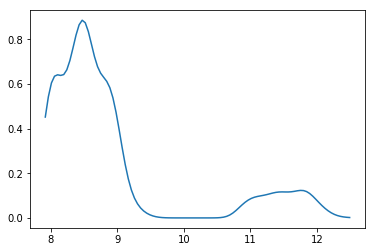

In [65]:
plot_distribution(ukhls_3_friends_sii_all)

In [31]:
def estimate_props(df, dims=['sex','age','ethnicity','employment','distance'], n_max=3):
    df = df.copy()
    df['distance'] = 'close'
    var_oi = [d for d in dims if d in list(df)]
    
    def classify_age_fine(x, granularity=7):
        if np.isnan(x) or x < 16: return np.nan
        else: return str(int(x/granularity)*granularity)
        
    def classify_age(x):
        if np.isnan(x) or x < 16: return np.nan
        #elif x < 16: return 'child'
        elif x < 25: return 'young'
        elif x < 45: return 'adult'
        elif x < 65: return 'middle'
        else: return 'senior'
        
    def classify_distance(x):
        if np.isnan(x) or x < 1: return np.nan
        elif x in [1,2]: return 'close'
        else: return 'far'
    
    def sim_func(a, b):
        if type(a)==type(b)==str:
            set_a = set(a.split('&'))
            set_b = set(b.split('&'))
            return len(set_a & set_b)/len(set_a | set_b)
        else:
            return np.nan
    #df['age'] = df['age'].apply(classify_age)
    df['age'] = df['age'].apply(classify_age_fine)
    for i in range(1, n_max+1):
        #df['age'+'#'+str(i)] = df['age'+'#'+str(i)].apply(classify_age)
        df['age'+'#'+str(i)] = df['age'+'#'+str(i)].apply(classify_age_fine)
        df['distance'+'#'+str(i)] = df['distance'+'#'+str(i)].apply(classify_distance)
    dfs = dict()
    for var in var_oi:
        dist = []
        for i in range(1, n_max+1): dist.append(df.apply(lambda x: sim_func(x[var], x[var+'#'+str(i)]), axis=1))
        dfs[var] = df[var]
        dfs[var+'_prop'] = pd.concat(dist, axis=1).mean(axis=1)
    del dfs['distance']
    return pd.DataFrame(dfs)

In [32]:
ukhls_3_nominees_props = estimate_props(ukhls_3_nominees)

In [86]:
ukhls_3_nominees_props_homophily = estimate_homophily(ukhls_3_nominees_props)

In [87]:
ukhls_3_nominees_props_homophily

,alpha_rho,beta_rho,rho,k,extremality,alpha,beta,apparent_homophily
age_prop,20012.166667,18614.833333,0.518088,13.0,0.477928,2.751707,-0.937680,-3.689387
distance_prop,21576.333333,17252.666667,0.555676,NaN,NaN,NaN,NaN,NaN
employment_prop,20001.000000,18817.000000,0.515251,5.0,0.394063,1.365274,-0.722761,-2.088035
ethnicity_prop,35949.194444,2378.805556,0.937936,4.0,0.917247,1.907561,-3.595052,-5.502613
sex_prop,32612.833333,6261.166667,0.838937,2.0,0.677874,0.746634,-1.634302,-2.380936


In [88]:
ukhls_3_friends_homophily

,alpha_rho,beta_rho,rho,k,extremality,alpha,beta,apparent_homophily
age_prop,33258.75,11697.25,0.739807,13.0,0.718124,3.265660,-1.826867,-5.092527
distance_prop,23502.25,18498.75,0.559564,NaN,NaN,NaN,NaN,NaN
education_prop,33277.00,10719.00,0.756364,4.0,0.675152,1.597153,-1.622165,-3.219318
employment_prop,20629.25,4405.75,0.824016,2.0,0.648033,0.720745,-1.506487,-2.227232
ethnicity_prop,36997.75,7952.25,0.823087,4.0,0.764116,1.719116,-2.083849,-3.802965
income_prop,23476.00,15623.00,0.600425,6.0,0.520509,1.849017,-1.060426,-2.909443


In [69]:
ukhls_3_nominees_props_sii = estimate_sii(ukhls_3_nominees_props)

In [70]:
ukhls_3_nominees_props_sii

{'ethnicity': {'white': 0.7846382140530319,
  'black': 5.265930018116417,
  'asian': 5.015528284216449,
  'other': 5.441741548594066},
 'sex': {'female': 1.0906122768263617, 'male': 1.2903240978736152},
 'employment': {'employed': 0.9369438485736131,
  'student': 1.9387071837588248,
  'unemployed': 1.8964317802498352,
  'retired': 1.6164149566103514,
  'housework': 1.9636442142298671},
 'age': {'28': 3.2943738696248444,
  '21': 3.338659868277536,
  '56': 3.312028924364108,
  '14': 3.384800389486873,
  '42': 3.197938696679285,
  '35': 3.235622595030319,
  '63': 3.316628140304589,
  '49': 3.242002152625179,
  '70': 3.4341306894936396,
  '77': 3.525818284694187,
  '84': 3.623811256587329,
  '91': 3.678260038850437,
  '98': 3.688571184265385}}

In [71]:
ukhls_3_nominees_props_sii_all = apply_sii(ukhls_3_nominees_props, ukhls_3_nominees_props_sii)

47159


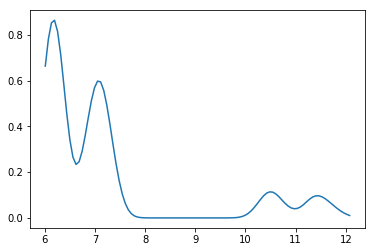

In [72]:
plot_distribution(ukhls_3_nominees_props_sii_all)

49739


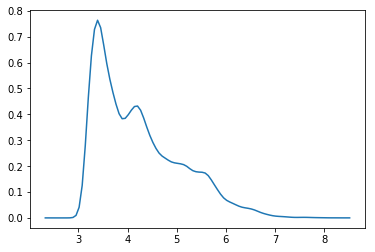

In [73]:
plot_distribution(ukhls_3_nominees_sii)

In [ ]:
ukhls_6 = read_data('ukhls', 6, 'indresp')
ukhls_6_nominees = extract_nominees(ukhls_6)
ukhls_6_friends = extract_friends(ukhls_6)
ukhls_6_nomprops = estimate_props(ukhls_6_nominees)

In [491]:
ukhls_6_friends_homophily = estimate_homophily(ukhls_6_friends)
ukhls_6_nominees_homophily = estimate_homophily(ukhls_6_nomprops)

In [492]:
ukhls_6_friends_homophily

,alpha,beta,prob_diff_friend,prob_diff_random,uncorrected_homophily,homophily
age_prop,15199.9375,41087.8125,0.270040,0.725479,-1.888756,-1.425761
distance_prop,23570.1875,29826.3125,0.441418,NaN,-1.179782,NaN
education_prop,12745.6875,41893.5625,0.233270,0.714139,-2.099928,-1.614206
employment_prop,19192.0000,36778.0000,0.342898,0.491979,-1.544149,-0.520817
ethnicity_prop,9747.8750,46464.1250,0.173413,0.336071,-2.527718,-0.954554
income_prop,18384.2500,27020.7500,0.404895,0.590606,-1.304381,-0.544648


In [493]:
ukhls_6_nominees_homophily

,alpha,beta,prob_diff_friend,prob_diff_random,uncorrected_homophily,homophily
age_prop,8343.000000,27088.000000,0.235472,0.725479,-2.086374,-1.623380
distance_prop,15756.500000,19776.500000,0.443433,NaN,-1.173212,NaN
employment_prop,17384.666667,18134.333333,0.489447,0.616267,-1.030776,-0.332404
ethnicity_prop,2094.027778,32327.972222,0.060834,0.388466,-4.038978,-2.674839
sex_prop,5194.333333,30354.666667,0.146118,0.497441,-2.774798,-1.767397


In [55]:
def plot_scatter(list_trends, title=''):
    if not isinstance(list_trends, list): list_trends = [list_trends]
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(list_trends)):
        plt.scatter(list_trends[i].values, list_trends[i].index, label=str(i+1)+' '+list_trends[i].name)
    plt.title(title)
    plt.legend()
    plt.show()

In [74]:
ukhls_3_nominees_sii_unweighted = ukhls_3_distance_densities[0].sum(axis=1)
ukhls_3_nominees_sii_unweighted.name = 'nominees "unweighted" sii'

In [40]:
def mutual_information(df_orig, x='social_isolation_index', given=None, nbins=10):
    """Finds the adjusted mutual information between variables of interest, possibly conditioned on some variables."""
    df_orig = df_orig.copy()
    if not isinstance(x, str):
        try: df_orig = df_orig.join(x, how='inner')
        except: print('caution: column of same name already exists, ignoring given predictor', x.name)
        x = x.name    
    if not given is None:
        if not isinstance(given, str) and not isinstance(given, list) and not isinstance(given, tuple):
            try: df_orig = df_orig.join(given, how='inner')
            except: print('caution: column of same name already exists, ignoring given conditioned variable', given.name)
            given = given.name
    for dim in list(df_orig):
        if len(df_orig[dim].value_counts()) > nbins:
            df_orig[dim] = np.digitize(df_orig[dim], np.linspace(np.nanmin(df_orig[dim]), np.nanmax(df_orig[dim]), nbins))
    if given is None: dfs = [('null', df_orig)]
    else: dfs = df_orig.groupby(given)
    out = dict()
    cond_var_counts = dict()
    for cond_var, df in dfs:
        cond_var_counts[cond_var] = df.size
        h_x = dict()
        for dim in list(df):
            p_dim = df[dim].value_counts(normalize=True)
            h_x[dim] = -np.sum(p_dim*np.log2(p_dim))
        h_x = pd.Series(h_x)
        p_x = df[x].value_counts(normalize=True)
        mi = dict()
        given_x = df.groupby(x)
        for xi, y_given_xi in given_x:
            mi[xi] = dict()
            for ylab in list(df):
                yi_given_xi = y_given_xi.groupby(ylab)
                yi_given_xi = np.array([group.size for yi, group in yi_given_xi])
                p_yi_given_xi = yi_given_xi/np.sum(yi_given_xi)
                mi[xi][ylab] = -np.sum(p_yi_given_xi * np.log2(p_yi_given_xi))
        mi = pd.DataFrame(mi) * p_x
        out[cond_var] = (1 - mi.sum(axis=1)/h_x)
    cond_var_counts = pd.Series(cond_var_counts)
    cond_var_counts = cond_var_counts/np.sum(cond_var_counts)
    out = pd.DataFrame(out) * cond_var_counts
    out = out.sum(axis=1).sort_values()
    out.name = x
    return out

In [75]:
mi_wellbeing_age = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees['age'])
mi_wellbeing_old = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii)
mi_wellbeing_old_unwtd = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii_unweighted)
mi_wellbeing_new = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_props_sii_all)
mi_wellbeing_new_blaus = mutual_information(ukhls_3_wellbeing, ukhls_3_friends_sii_all)

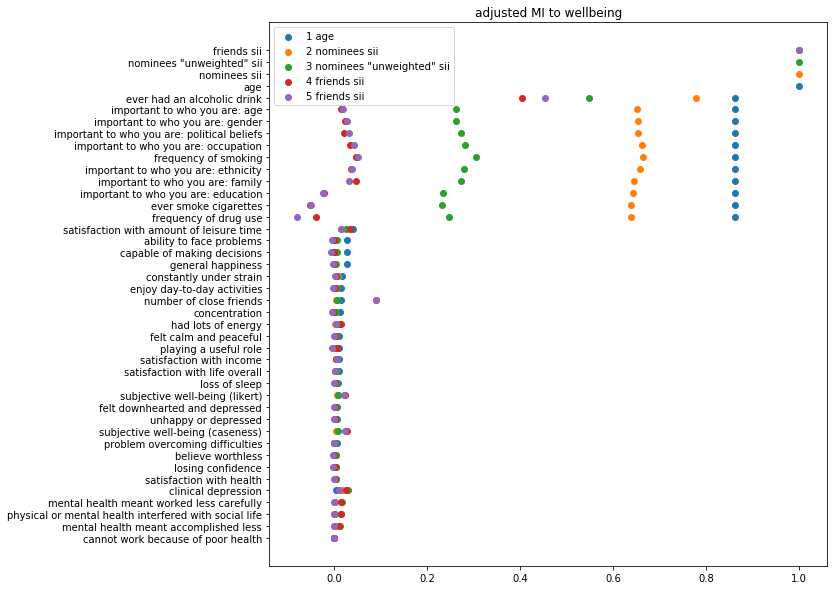

In [76]:
plot_scatter([mi_wellbeing_age, mi_wellbeing_old, mi_wellbeing_old_unwtd, mi_wellbeing_new, mi_wellbeing_new_blaus], 'adjusted MI to wellbeing')

In [78]:
mi_wellbeing_age_corr = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees['age'], given=ukhls_3_nominees['age'])
mi_wellbeing_old_corr = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii, given=ukhls_3_nominees['age'])
mi_wellbeing_old_unwtd_corr = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii_unweighted, given=ukhls_3_nominees['age'])
mi_wellbeing_new_corr = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_props_sii_all, given=ukhls_3_nominees['age'])
mi_wellbeing_new_blaus_corr = mutual_information(ukhls_3_wellbeing, ukhls_3_friends_sii_all, given=ukhls_3_nominees['age'])

caution: column of same name already exists, ignoring given conditioned variable age


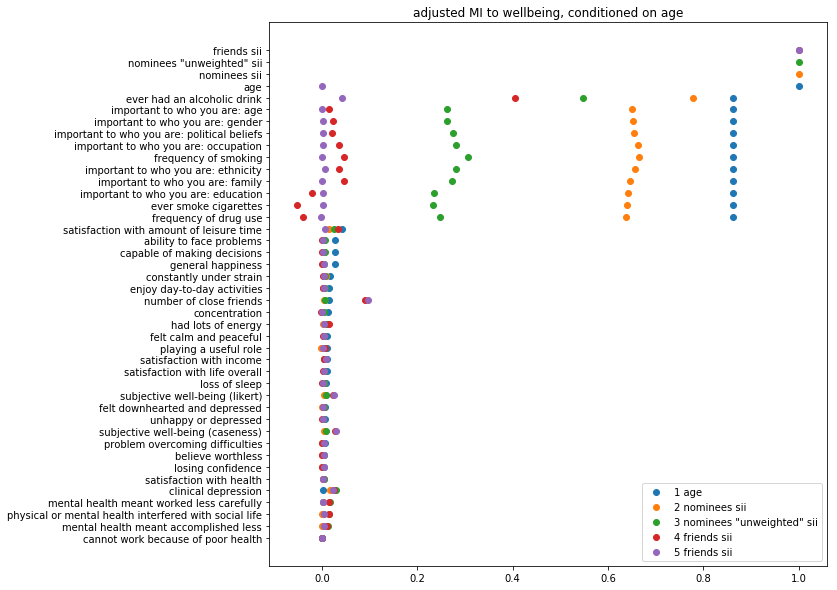

In [79]:
plot_scatter([mi_wellbeing_age, mi_wellbeing_old, mi_wellbeing_old_unwtd, mi_wellbeing_new, mi_wellbeing_new_blaus_corr], 'adjusted MI to wellbeing, conditioned on age')

In [80]:
mi_wellbeing_age_multiblau = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees['age'], given=[ukhls_3_nominees['age'], ukhls_3_nominees['sex'], ukhls_3_nominees['ethnicity']])
mi_wellbeing_old_multiblau = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii, given=[ukhls_3_nominees['age'], ukhls_3_nominees['sex'], ukhls_3_nominees['ethnicity']])
mi_wellbeing_old_unwtd_multiblau = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_sii_unweighted, given=[ukhls_3_nominees['age'], ukhls_3_nominees['sex'], ukhls_3_nominees['ethnicity']])
mi_wellbeing_new_multiblau = mutual_information(ukhls_3_wellbeing, ukhls_3_nominees_props_sii_all, given=[ukhls_3_nominees['age'], ukhls_3_nominees['sex'], ukhls_3_nominees['ethnicity']])
mi_wellbeing_new_blaus_multiblau = mutual_information(ukhls_3_wellbeing, ukhls_3_friends_sii_all, given=[ukhls_3_nominees['age'], ukhls_3_nominees['sex'], ukhls_3_nominees['ethnicity']])

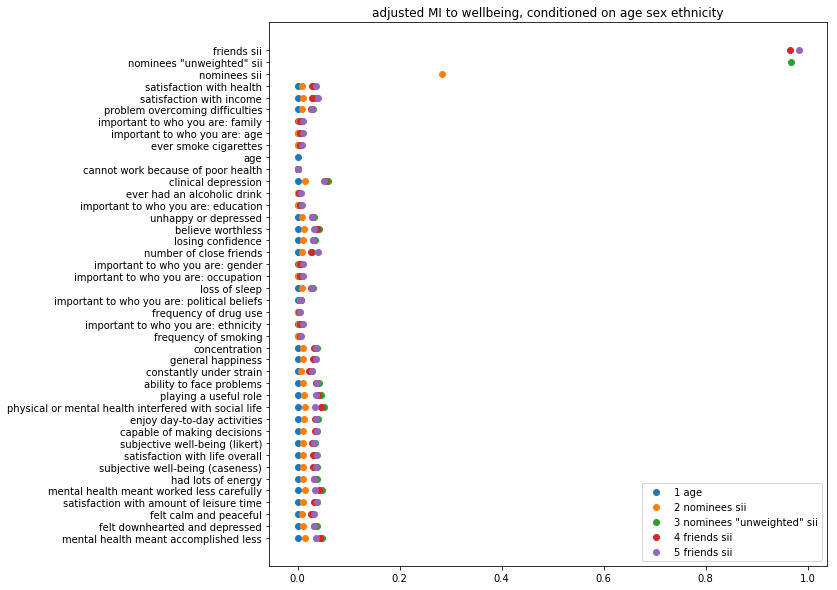

In [82]:
plot_scatter([mi_wellbeing_age_multiblau, mi_wellbeing_old_multiblau, mi_wellbeing_old_unwtd_multiblau, mi_wellbeing_new_multiblau, mi_wellbeing_new_blaus_multiblau], 'adjusted MI to wellbeing, conditioned on age sex ethnicity')

In [359]:
mi_health_age = mutual_information(nurse_health, ukhls_3_nominees['age'], given=ukhls_3_nominees['age'])
mi_health_old = mutual_information(nurse_health, ukhls_3_nominees_sii, given=ukhls_3_nominees['age'])
mi_health_old_unwtd = mutual_information(nurse_health, ukhls_3_nominees_sii_unweighted, given=ukhls_3_nominees['age'])
mi_health_new = mutual_information(nurse_health, ukhls_3_nominees_props_sii_all, given=ukhls_3_nominees['age'])

caution: column of same name already exists, ignoring given conditioned variable age


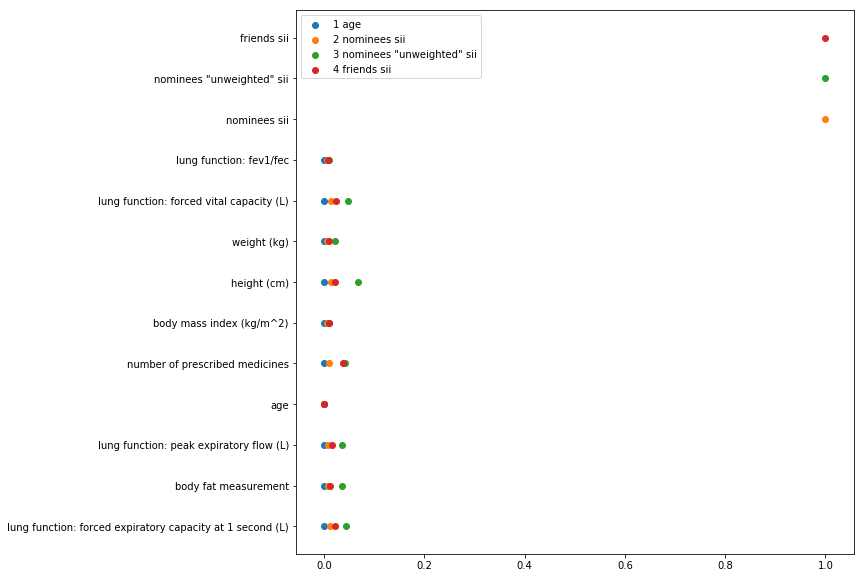

In [360]:
plot_scatter([mi_health_age, mi_health_old, mi_health_old_unwtd, mi_health_new])

In [361]:
mi_biomarkers_age = mutual_information(nurse_biomarkers, ukhls_3_nominees['age'], given=ukhls_3_nominees['age'])
mi_biomarkers_old = mutual_information(nurse_biomarkers, ukhls_3_nominees_sii, given=ukhls_3_nominees['age'])
mi_biomarkers_old_unwtd = mutual_information(nurse_biomarkers, ukhls_3_nominees_sii_unweighted, given=ukhls_3_nominees['age'])
mi_biomarkers_new = mutual_information(nurse_biomarkers, ukhls_3_nominees_props_sii_all, given=ukhls_3_nominees['age'])

caution: column of same name already exists, ignoring given conditioned variable age


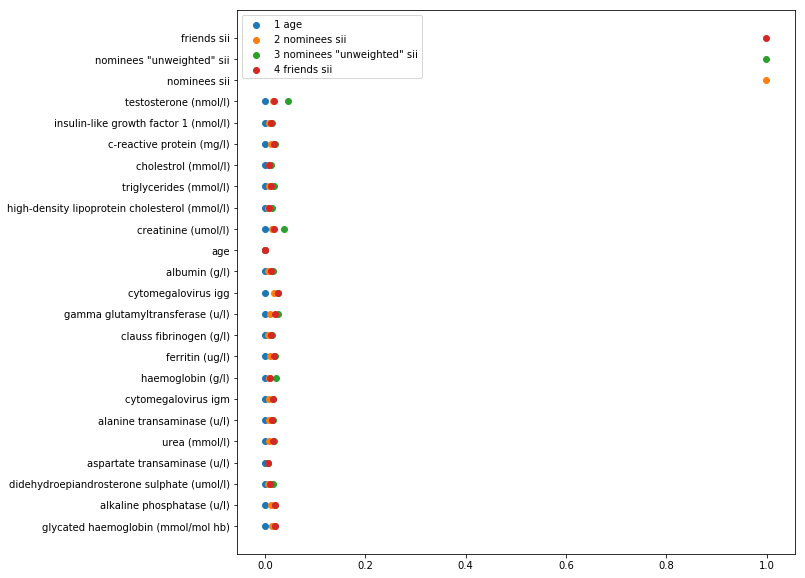

In [362]:
plot_scatter([mi_biomarkers_age, mi_biomarkers_old, mi_biomarkers_old_unwtd, mi_biomarkers_new])